In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from pyod.models.copod import COPOD
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import VotingClassifier
import joblib
from scipy import stats
import seaborn as sns
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
import pyarrow.parquet as pq

In [1]:
#FUNÇÕES GERAIS
#---------------função agrupa dados RGI--------------------------
def filtraMun(df):

    DADOS_AGP = df.groupby(['co_ibge','co_ibge_7','municipio','UF','ano','epiweek'])['atend_arbov'].sum()
    dataAGP = pd.DataFrame(DADOS_AGP)
    dataAGP.reset_index(inplace = True)

    return dataAGP


#---------------função agrupa dados RGI--------------------------
def filtraRGIs(df):

    DADOS_AGP = df.groupby(['cod_rgi','nome_rgi','UF','ano','epiweek'])['atend_arbov'].sum()
    dataAGP = pd.DataFrame(DADOS_AGP)
    dataAGP.reset_index(inplace = True)

    return dataAGP



#---------------função agrupa dados Nacional--------------------------
def filtraNacional(df):

    nacional = df.groupby(['ano','epiweek'])['atend_arbov'].sum()
    dataAGP = pd.DataFrame(nacional)
    dataAGP.reset_index(inplace = True)

    return dataAGP



##------------------função RT----------------------------------
def calculo_rt(n, m, gamma, q, serie):
    rt = [0] * n  
    w = [0.0] * (m + 1)  

    for i in range(1, n + 1):
        deno = 0.0  
        ie = min(i, m)  

        if ie > 1:
            ww = ((1 - q) ** 2) / (q * (1.0 + (ie - 1) * q ** ie - ie * q ** (ie - 1)))
            for j in range(1, ie + 1):
                w[j] = ww * (j - 1) * q ** (j - 1)  
                deno += w[j] * serie[i - j]  

            if deno != 0:
                rt[i - 1] = serie[i - 1] / deno  

    return rt


##------------------função RT VETORIAL----------------------------------
def calculo_rt_vector(n, mi_h, mi_v, gamma_h, q, serie):
    rt_v = [0] * n  
    g = [0] * (n + 1)  # Criar um vetor para armazenar valores de g(j)

    # Pré-calcular os valores de g(j)
    for j in range(n + 1):  # O somatório começa em j = 0
        g[j] = (gamma_h + mi_h) ** 2 * mi_v * math.exp(-j * mi_v) * (
            ((q - q ** (-j)) / (1 - q) ** 2) + ((j + 1) * q ** (-j) / (1 - q))
        )

    # Calcular R_v(i)
    for i in range(n):
        deno = 0.0  
        for j in range(i + 1):  # Somatório de j=0 até i
            deno += g[j] * serie[i - j]  

        if deno != 0:
            rt_v[i] = (serie[i] / deno)**1/2   

    return rt_v


#---------------ML-------------------------------------
def treina_Models_ensemble(data_T, data_V):

    # cria os modelos Isolation Forest, Local Outilier Factory e One class SVM
    ISF = IsolationForest(n_estimators = 500, contamination=0.2, random_state=1)
    LOF = LocalOutlierFactor(n_neighbors = 500, contamination= 0.2)
    OCSVM = OneClassSVM(nu = 0.8, kernel='rbf', gamma=0.01)
    COPO = COPOD(contamination = 0.3)

    ISF.fit(data_T)
    LOF.fit(data_T)
    OCSVM.fit(data_T)
    COPO.fit(data_T)


    ISF_Pred = ISF.predict(data_V)
    LOF_Pred = LOF.fit_predict(data_V)
    OCSVM_Pred = OCSVM.predict(data_V)
    COPO_Pred = COPO.predict(data_V)

# Ajuste para COPOD
    COPO_Pred = COPO.predict(data_V)  # COPOD retorna 0 (normal) e 1 (anômalo)
    COPO_Pred = np.where(COPO_Pred == 1, -1, 1)  # Ajustar para -1 (anômalo) e 1 (normal)

    ENSEMBLE_Pred = ISF_Pred+LOF_Pred+OCSVM_Pred+COPO_Pred


    return ISF_Pred, LOF_Pred, OCSVM_Pred, COPO_Pred, ENSEMBLE_Pred

#------------------Limite historico----------------------------------
def calculate_limit_sazonal(df_rgi, alpha=0.05):
    limits = []
    ano = df_rgi['ano']
    epiweek = df_rgi['epiweek']

    # Itere sobre todas as semanas e anos
    for a, w in zip(ano, epiweek):
        # Se o ano for 2020 ou posterior
        if a >= 2020:
            # Filtre os dados de 2017 a 2019 para a semana atual
            filtered_df = df_rgi[(df_rgi['ano'].isin([2017, 2018, 2019])) & (df_rgi['epiweek'] == w)]
            data_week = filtered_df['atend_arbov']
            media = np.mean(data_week)
            desvio_padrao = np.std(data_week, ddof=0)
            z_alpha = stats.norm.ppf(1 - alpha / 2)
            # Calcule o limite usando a fórmula fornecida
            limit = media + z_alpha * (desvio_padrao / np.sqrt(len(data_week)))
            limits.append(limit)

    return limits




#--------------------- Limite passado recente -------------------------------
def calculate_limit(serie, l=5, alpha=0.05):
    n = len(serie)
    z_alpha = stats.norm.ppf(1 - alpha / 2)

    actual_l = min(l, n)
    media_movel = np.convolve(serie, np.ones(actual_l) / actual_l, mode='valid')
    media_movel = np.concatenate(([media_movel[0]] * (actual_l - 1), media_movel))

    variabilidade = [np.std(serie[max(0, i-(actual_l-1)):i+1]) for i in range(n)]
    variabilidade = np.array(variabilidade)

    threshold = media_movel + z_alpha * variabilidade / np.sqrt(actual_l)
    return threshold



In [4]:
# --------- LEITURA DO DADOS APS ---------------------
df = pd.read_csv('dados/xxx.csv')
display(df)


municipio  co_ibge   ano  epiweek  atend_totais  \
0        Alta Floresta D´oeste   110001  2017        8           821   
1        Alta Floresta D´oeste   110001  2017       25           754   
2        Alta Floresta D´oeste   110001  2017       26           777   
3        Alta Floresta D´oeste   110001  2018       15           547   
4        Alta Floresta D´oeste   110001  2018       25           371   
...                        ...      ...   ...      ...           ...   
2598322               Brasília   530010  2022       46         62665   
2598323               Brasília   530010  2022       48         47702   
2598324               Brasília   530010  2023       21         95201   
2598325               Brasília   530010  2023       33         92706   
2598326               Brasília   530010  2024        8        127199   

         atend_ivas  atend_arbov  sinan  cod_rgi          nome_rgi  co_ibge_7  \
0                21            2      0   110005            Cacoal    1100015   
1                23            0      1   110005            Cacoal    1100015   
2                16            0      0   110005            Cacoal    1100015   
3                16            0      0   110005            Cacoal    1100015   
4                11            0      0   110005            Cacoal    1100015   
...             ...          ...    ...      ...               ...        ...   
2598322        7804          246    323   530001  Distrito Federal    5300108   
2598323        9562          184    471   530001  Distrito Federal    5300108   
2598324       10764          579    737   530001  Distrito Federal    5300108   
2598325        7672          248    364   530001  Distrito Federal    5300108   
2598326       13210        33036  21376   530001  Distrito Federal    5300108   

         uf_code  UF   pop_2022  
0             11  RO    22516.0  
1             11  RO    22516.0  
2             11  RO    22516.0  
3             11  RO    22516.0  
4             11  RO    22516.0  
...          ...  ..        ...  
2598322       53  DF  2817381.0  
2598323       53  DF  2817381.0  
2598324       53  DF  2817381.0  
2598325       53  DF  2817381.0  
2598326       53  DF  2817381.0  

[2598327 rows x 14 columns]

In [11]:
rgis_list = sorted([

    130001,  # Manaus, Amazonas
    290001,  # Salvador, Bahia
    230001,  # Fortaleza, Ceará
    530001,  # Brasília, Distrito Federal
    310001,  # Belo Horizonte, Minas Gerais
    150001,  # Belém, Pará
    410001,  # Curitiba, Paraná
    330001,  # Rio de Janeiro, Rio de Janeiro
    430001,  # Porto Alegre, Rio Grande do Sul
    350001,  # São Paulo, São Paulo
    290022,  # Juazeiro, Bahia
])

## ARTIGO - Processamento por municipios

In [4]:
lista_capitais = [
    120040,  # Rio Branco - AC
    270430,  # Maceió - AL
    130260,  # Manaus - AM
    160030,  # Macapá - AP
    292740,  # Salvador - BA
    230440,  # Fortaleza - CE
    530010,  # Brasília - DF
    320530,  # Vitoria - ES 
    520870,  # Goiânia - GO
    211130,  # São Luís - MA
    310620,  # Belo Horizonte - MG
    500270,  # Campo Grande - MS
    510340,  # Cuiabá - MT
    150140,  # Belém - PA
    250750,  # João Pessoa - PB
    261160,  # Recife - PE
    221100,  # Teresina - PI
    410690,  # Curitiba - PR
    330455,  # Rio de Janeiro - RJ
    240810,  # Natal - RN
    110020,  # Porto Velho - RO
    140010,  # Boa Vista - RR
    431490,  # Porto Alegre - RS
    420910,  # Joinville - SC (mais populosa, não é a capital)
    280030,  # Aracaju - SE
    355030,  # São Paulo - SP
    172100   # Palmas - TO
]

In [ ]:
# %%time
# Suprimir avisos
import warnings
warnings.filterwarnings("ignore")

dadosAGP = filtraMun(df)

# Obter todas as regiões únicas no dataframe
rgis = dadosAGP['co_ibge'].unique()

# DataFrame resultado final
result_final = pd.DataFrame()

# Processamento para cada região
for rgi in rgis:
#for rgi in lista_capitais:
    df_rgi = dadosAGP[dadosAGP['co_ibge'] == rgi]

    # divide dados
    DADOS_TREINO = df_rgi[(df_rgi['ano'] >= 2017) & (df_rgi['ano'] <= 2019)]
    DADOS_DETECCAO = df_rgi[df_rgi['ano'] >= 2020]

    # Cálculos para abordagem rt a partir de 2020
    n = len(DADOS_DETECCAO)
    gamma_h=0.58 #0.50
    mi_h=0.0
    mi_v=0.14 #0.192
    q = math.exp(mi_h+gamma_h-mi_v)
    serie = DADOS_DETECCAO['atend_arbov']
    rt = calculo_rt_vector(n, mi_h, mi_v, gamma_h, q, serie.to_numpy())
    #rt = calculo_rt(n, m, gamma, q, serie.to_numpy())

    #-------limites-------------
    limite1 = calculate_limit_sazonal(df_rgi)
    limite2 = calculate_limit(serie)

    DADOS_DETECCAO['limite1'] = limite1
    DADOS_DETECCAO['limite2'] = limite2
    DADOS_DETECCAO['limite_max'] = DADOS_DETECCAO[['limite1', 'limite2']].max(axis=1)
    DADOS_DETECCAO['excesso'] = DADOS_DETECCAO['atend_arbov'] - DADOS_DETECCAO['limite_max']


    #-------------normaliza dados de treino------------------------
    scaler1 = MinMaxScaler()
    dados_T = np.reshape(DADOS_TREINO['atend_arbov'].values, (-1, 1))
    dados_T = scaler1.fit_transform(dados_T)

    scaler2 = MinMaxScaler()
    dados_V = np.reshape(DADOS_DETECCAO['atend_arbov'].values, (-1, 1))
    dados_V = scaler2.fit_transform(dados_V)

    #-------- Abordagem de aprendizado de máquina--------
    ISF_Pred, LOF_Pred, OCSVM_Pred, COPOD_Pred, ENSEMBLE_Pred = treina_Models_ensemble(dados_T, dados_V)
    dados2 = scaler2.inverse_transform(dados_V)

    # -----------Ensemble Final--------------------------------
    VOT1 = -1
    limiar_rt = 1.25


    final_alerta = []
    for i in range(n):
        votos = sum([ ISF_Pred[i] == VOT1, LOF_Pred[i] == VOT1, OCSVM_Pred[i] == VOT1, COPOD_Pred[i] == VOT1])
        if rt[i] > limiar_rt:
            votos += 1
        is_anomalia = "Sim" if votos >= 3 else "Não" # definir nº votos
        final_alerta.append("Sim" if (is_anomalia == "Sim" and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else "Não")

    #-------------- early warning signals (EWS)--------------------
    DADOS_DETECCAO['EWS_ISF'] = ['Sim' if (ISF_Pred[i] == VOT1 and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else 'Não' for i in range(n)]
    DADOS_DETECCAO['EWS_LOF'] = ['Sim' if (LOF_Pred[i] == VOT1 and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else 'Não' for i in range(n)]
    DADOS_DETECCAO['EWS_OCSVM'] = ['Sim' if (OCSVM_Pred[i] == VOT1 and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else 'Não' for i in range(n)]
    DADOS_DETECCAO['EWS_COPOD'] = ['Sim' if (COPOD_Pred[i] == VOT1 and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else 'Não' for i in range(n)]
    DADOS_DETECCAO['rt'] = rt
    DADOS_DETECCAO['EWS_Rt'] = ['Sim' if (rt[i] > limiar_rt and dados2[i][0] > DADOS_DETECCAO['limite_max'].iloc[i]) else 'Não' for i in range(len(rt))]
    DADOS_DETECCAO['EWS_MMAING_VECTOR'] = final_alerta

    # Salva arquivo de resultado individualizado
    # DataFrame final
    result_final = pd.concat([result_final, DADOS_DETECCAO])

result_final.rename(columns={'ano': 'epiyear', 'limite_max':'upperbound','municipio':'name_cod', 'co_ibge_7':'cod_ibge7'}, inplace=True)

# Salva arquivo final
result_final.to_csv('resultados/xxx.csv', index=False, sep=';')





In [13]:
result_final.head(10)

co_ibge  cod_ibge7    name_cod  UF  epiyear  epiweek  atend_arbov  \
27678   120040    1200401  Rio Branco  AC     2020        1            8   
27679   120040    1200401  Rio Branco  AC     2020        2            2   
27680   120040    1200401  Rio Branco  AC     2020        3            6   
27681   120040    1200401  Rio Branco  AC     2020        4            6   
27682   120040    1200401  Rio Branco  AC     2020        5            6   
27683   120040    1200401  Rio Branco  AC     2020        6            6   
27684   120040    1200401  Rio Branco  AC     2020        7           12   
27685   120040    1200401  Rio Branco  AC     2020        8            4   
27686   120040    1200401  Rio Branco  AC     2020        9            6   
27687   120040    1200401  Rio Branco  AC     2020       10           14   

         limite1    limite2  upperbound    excesso EWS_ISF EWS_LOF EWS_OCSVM  \
27678  19.068895   5.600000   19.068895 -11.068895     Não     Não       Não   
27679  15.847872   8.229568   15.847872 -13.847872     Não     Não       Não   
27680  53.940806   7.786431   53.940806 -47.940806     Não     Não       Não   
27681  32.502969   7.510337   32.502969 -26.502969     Não     Não       Não   
27682  32.382632   7.317626   32.382632 -26.382632     Não     Não       Não   
27683  55.049035   6.602436   55.049035 -49.049035     Não     Não       Não   
27684  42.289623   9.303654   42.289623 -30.289623     Não     Não       Não   
27685  46.712430   9.177946   46.712430 -42.712430     Não     Não       Não   
27686  70.856204   9.177946   70.856204 -64.856204     Não     Não       Não   
27687  16.054686  11.799281   16.054686  -2.054686     Não     Não       Não   

      EWS_COPOD        rt EWS_Rt EWS_MMAING_VECTOR  
27678       Não  0.000000    Não               Não  
27679       Não  4.205922    Não               Não  
27680       Não  5.521820    Não               Não  
27681       Não  3.126876    Não               Não  
27682       Não  2.053251    Não               Não  
27683       Não  1.495206    Não               Não  
27684       Não  2.346312    Não               Não  
27685       Não  0.612790    Não               Não  
27686       Não  0.773803    Não               Não  
27687       Não  1.595850    Não               Não

In [69]:
def plot_alerta_mun(result_final, cod, col_EWS='EWS_COPOD', title=None):
    """
    Gera gráfico para um município com atendimentos por arboviroses e alertas do modelo especificado.

    Parâmetros:
        result_final: DataFrame com os dados (como o exportado por EWS_mun_completed.csv)
        cod: Código do município (ex: 330455)
        col_EWS: Coluna do alerta a ser plotado (default: 'EWS_MMAING_ARBO')
        title: Título opcional do gráfico
    """
    df_mun = result_final[result_final['co_ibge'] == cod].copy()

    if df_mun.empty:
        print(f"Nenhum dado encontrado para o município {cod}")
        return

    df_mun = df_mun.sort_values(by=['epiyear', 'epiweek']).reset_index(drop=True)
    df_mun['semanas'] = range(1, len(df_mun) + 1)

    # Ticks no início de cada ano
    anos = df_mun['epiyear'].unique()
    ticks = [df_mun[df_mun['epiyear'] == ano]['semanas'].iloc[0] for ano in anos]

    print(f"Plotando Município {cod}: {len(df_mun)} semanas. Alertas encontrados: {df_mun[col_EWS].value_counts().to_dict()}")

    plt.figure(figsize=(18, 6))
    plt.plot(df_mun['semanas'], df_mun['atend_arbov'], color='black', label='Casos semanais')

    alertas = df_mun[df_mun[col_EWS] == "Sim"]
    if not alertas.empty:
        plt.scatter(alertas['semanas'], alertas['atend_arbov'], color='red', label='Alerta EWS', s=50)

    plt.title(title if title else f'Alerta {col_EWS} - Município {cod}', fontsize=20)
    plt.xlabel('Ano', fontsize=18)
    plt.ylabel('Atendimentos por arboviroses', fontsize=18)
    plt.xticks(ticks, anos, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


Plotando Município 120040: 261 semanas. Alertas encontrados: {'Não': 246, 'Sim': 15}


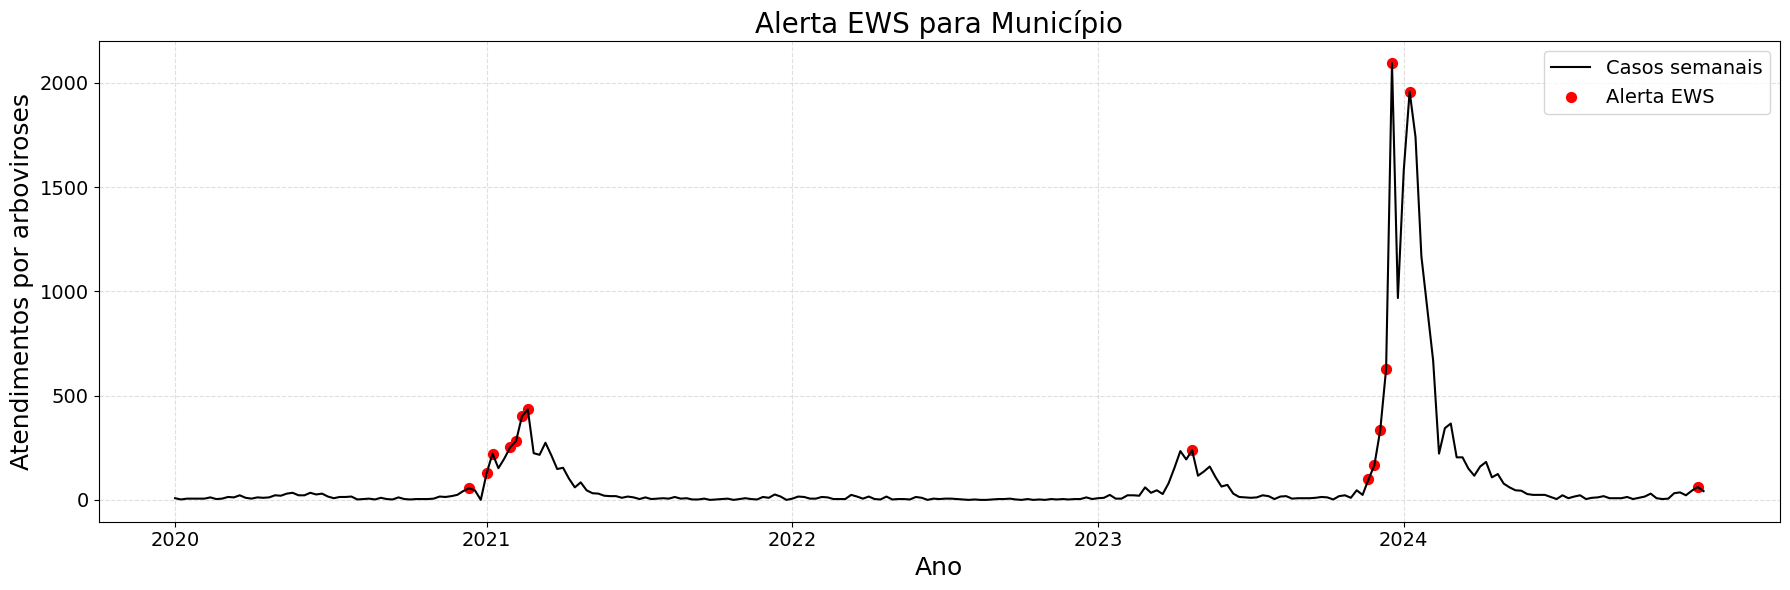

Plotando Município 270430: 261 semanas. Alertas encontrados: {'Não': 239, 'Sim': 22}


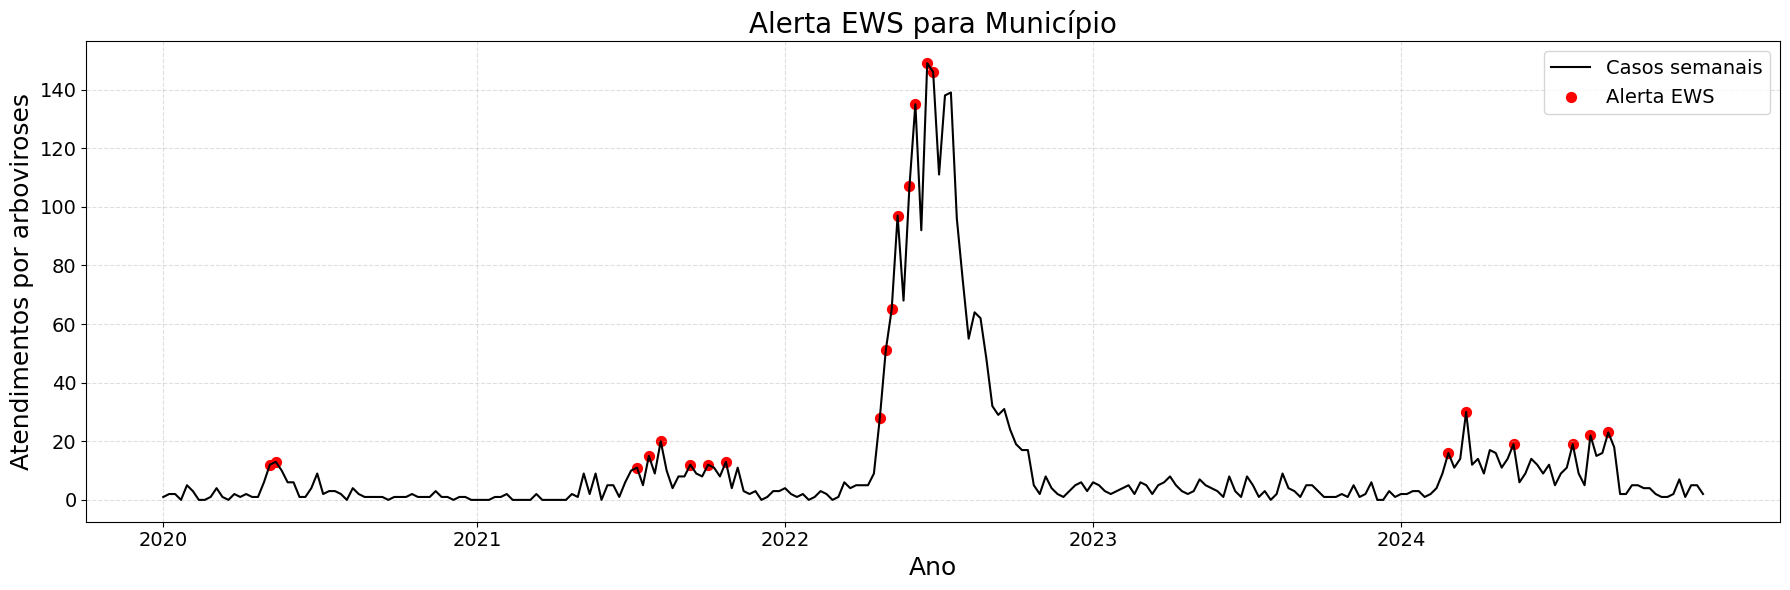

Plotando Município 130260: 261 semanas. Alertas encontrados: {'Não': 217, 'Sim': 44}


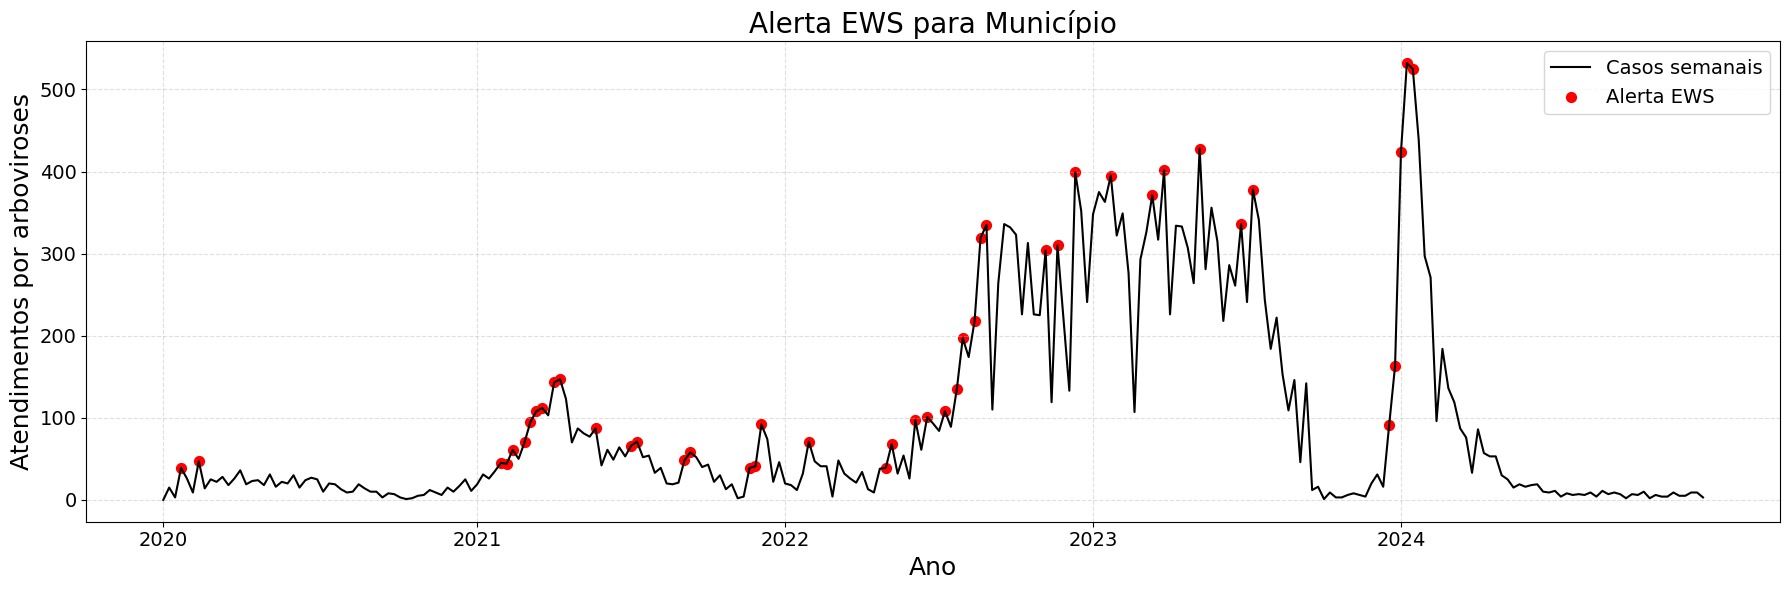

Plotando Município 160030: 261 semanas. Alertas encontrados: {'Não': 236, 'Sim': 25}


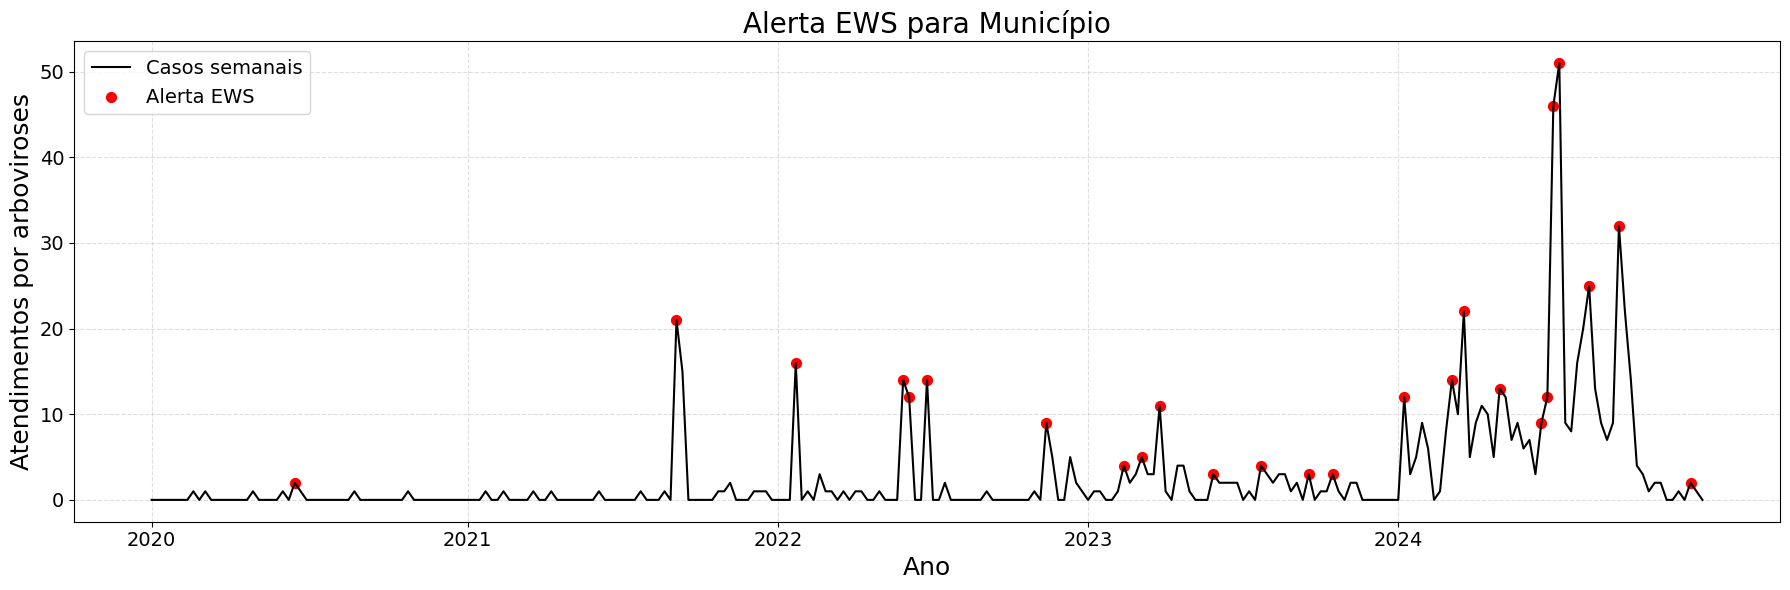

Plotando Município 292740: 261 semanas. Alertas encontrados: {'Não': 245, 'Sim': 16}


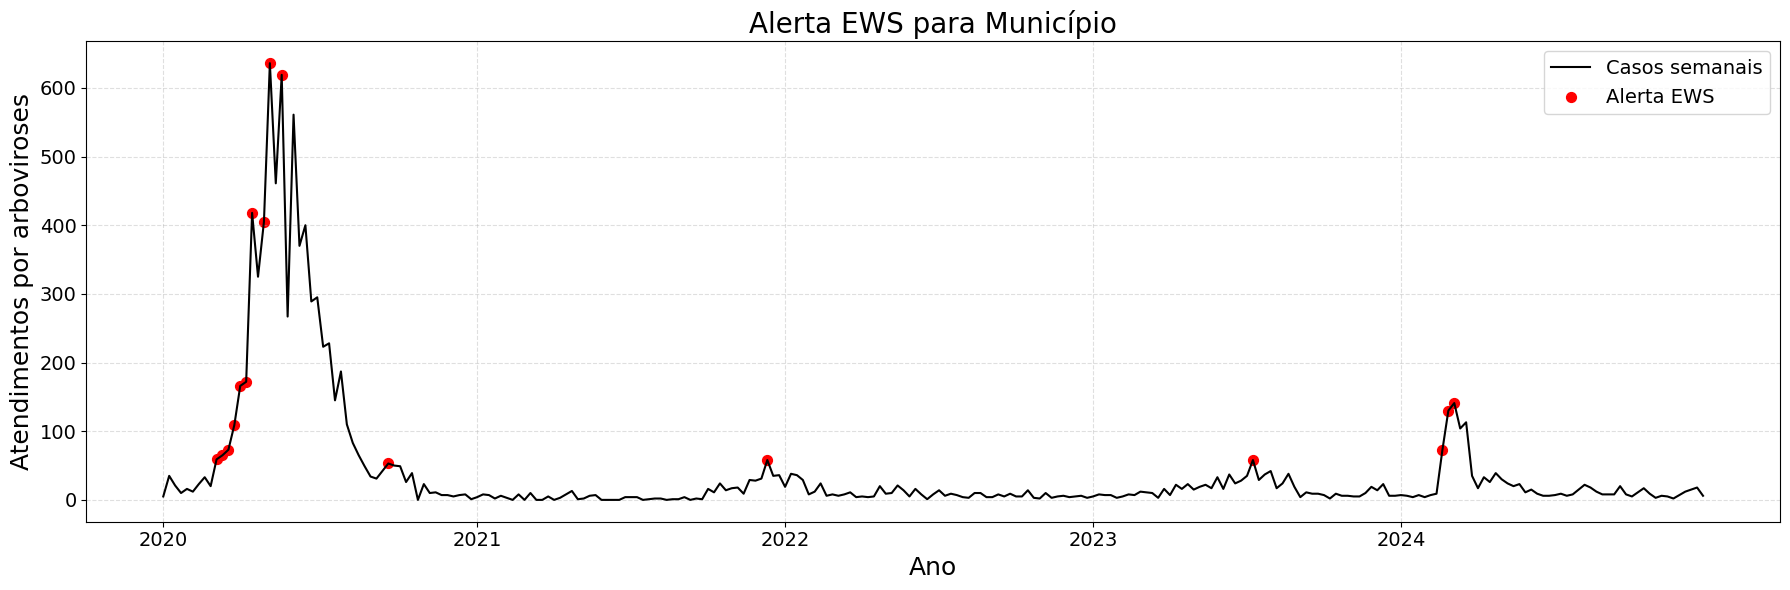

Plotando Município 230440: 261 semanas. Alertas encontrados: {'Não': 258, 'Sim': 3}


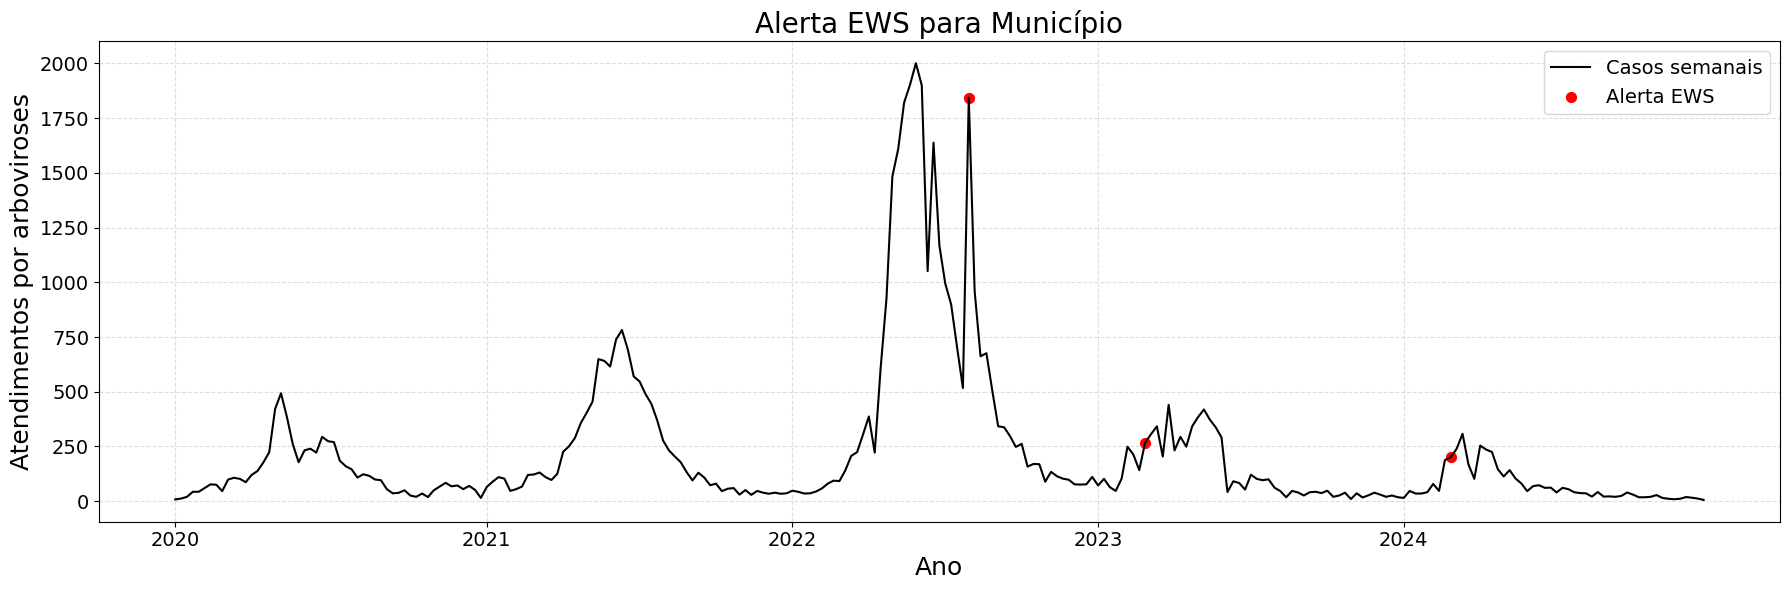

Plotando Município 530010: 261 semanas. Alertas encontrados: {'Não': 229, 'Sim': 32}


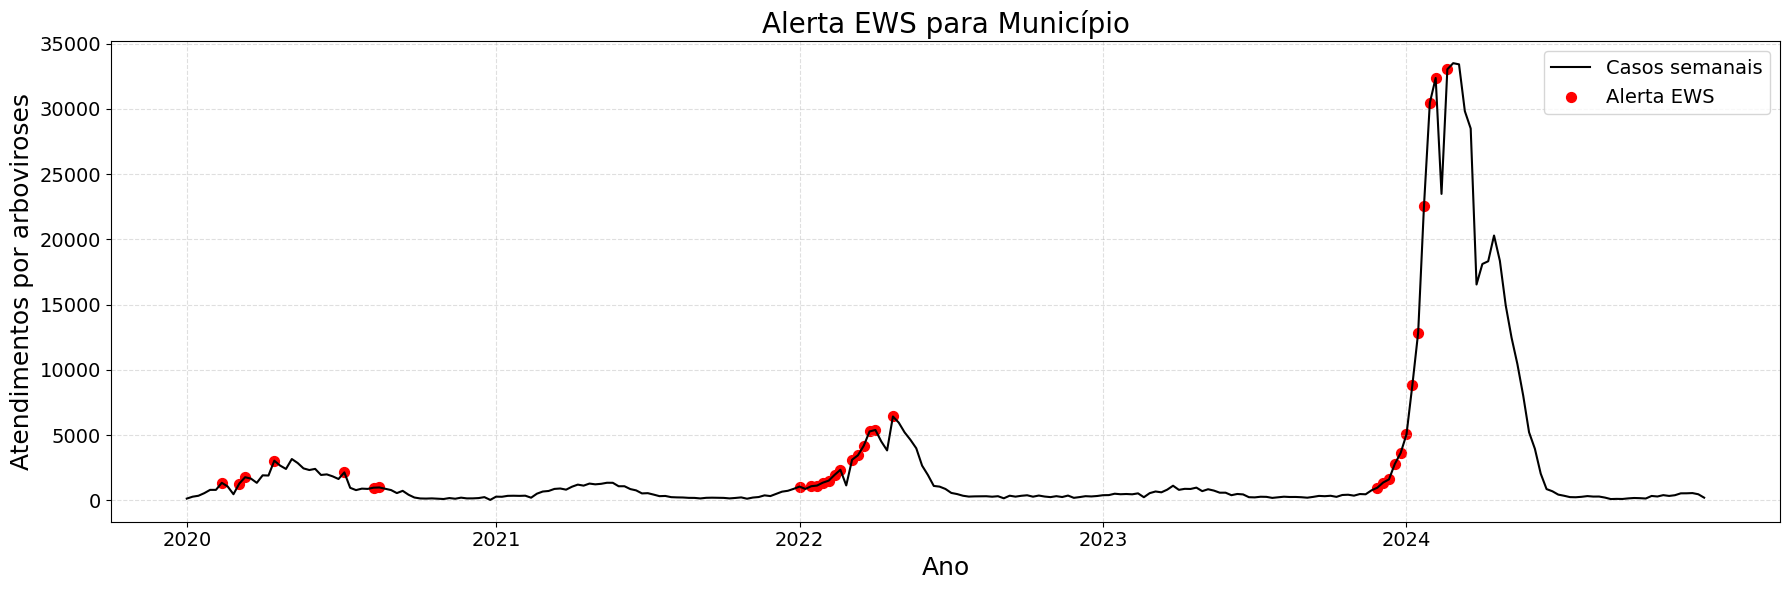

Plotando Município 320530: 261 semanas. Alertas encontrados: {'Não': 242, 'Sim': 19}


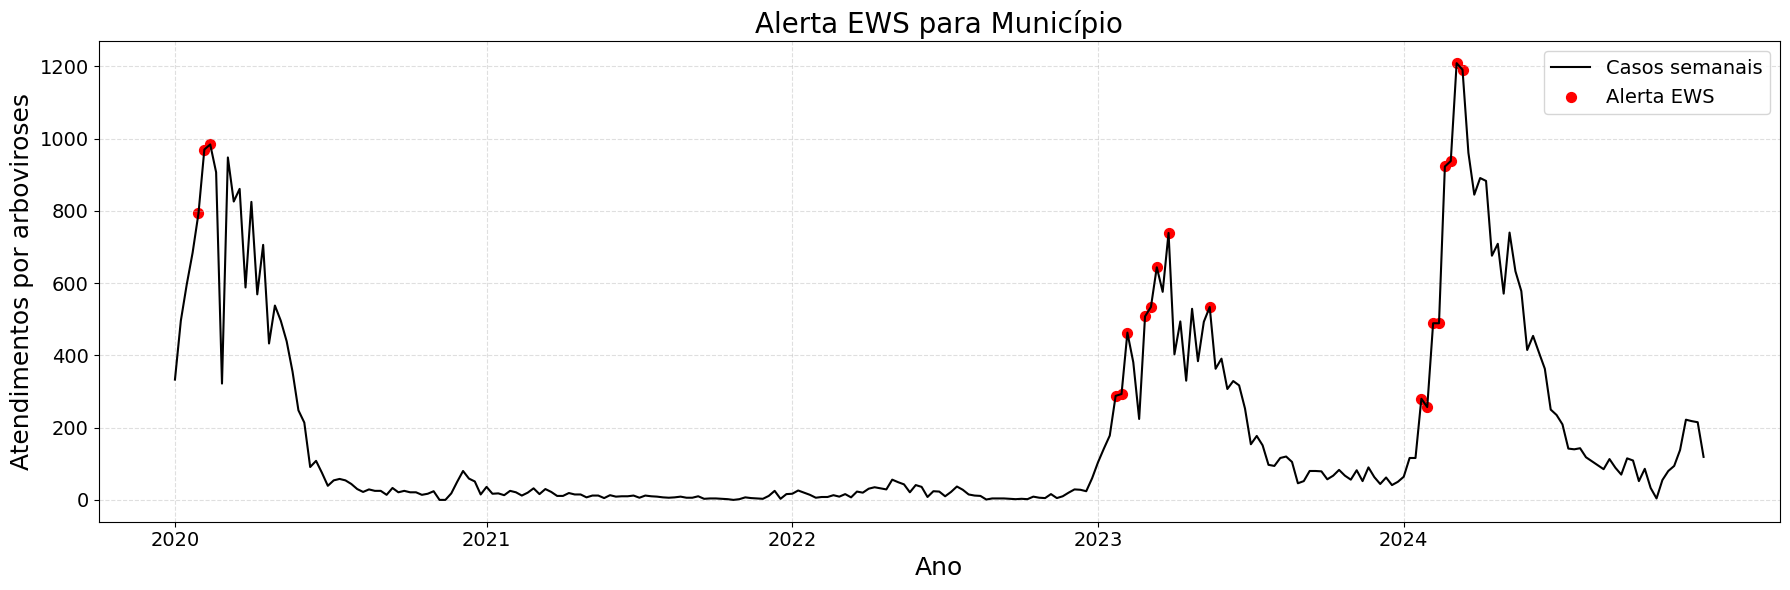

Plotando Município 520870: 261 semanas. Alertas encontrados: {'Não': 242, 'Sim': 19}


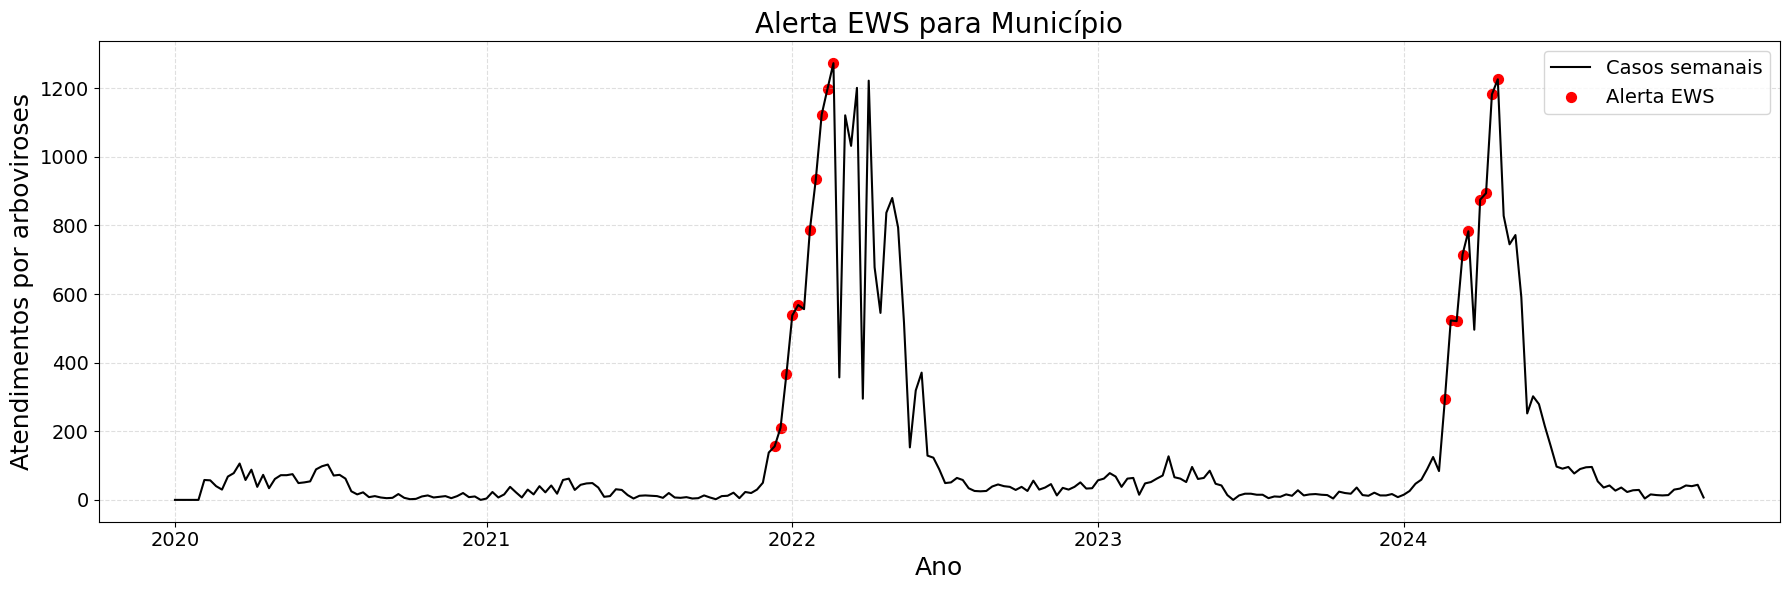

Plotando Município 211130: 261 semanas. Alertas encontrados: {'Não': 213, 'Sim': 48}


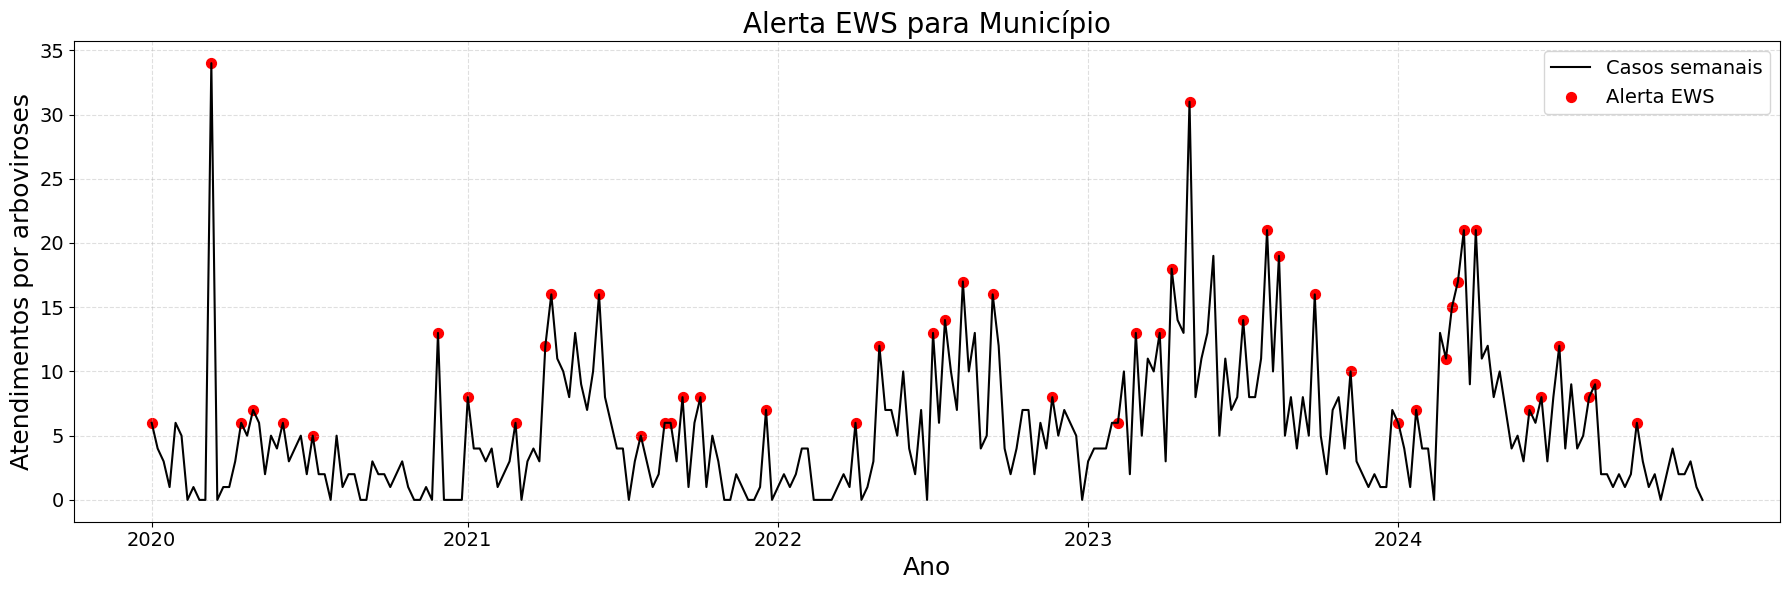

Plotando Município 310620: 261 semanas. Alertas encontrados: {'Não': 241, 'Sim': 20}


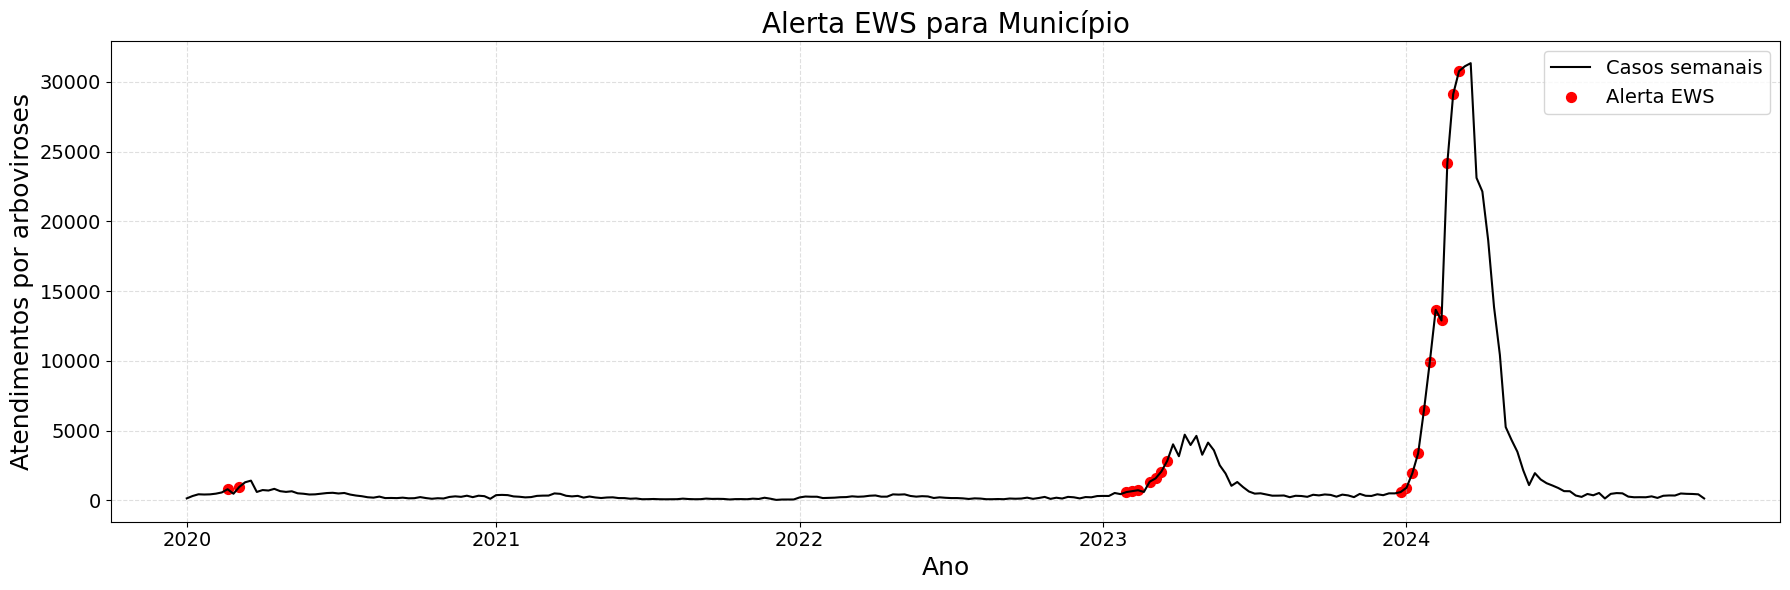

Plotando Município 500270: 261 semanas. Alertas encontrados: {'Não': 228, 'Sim': 33}


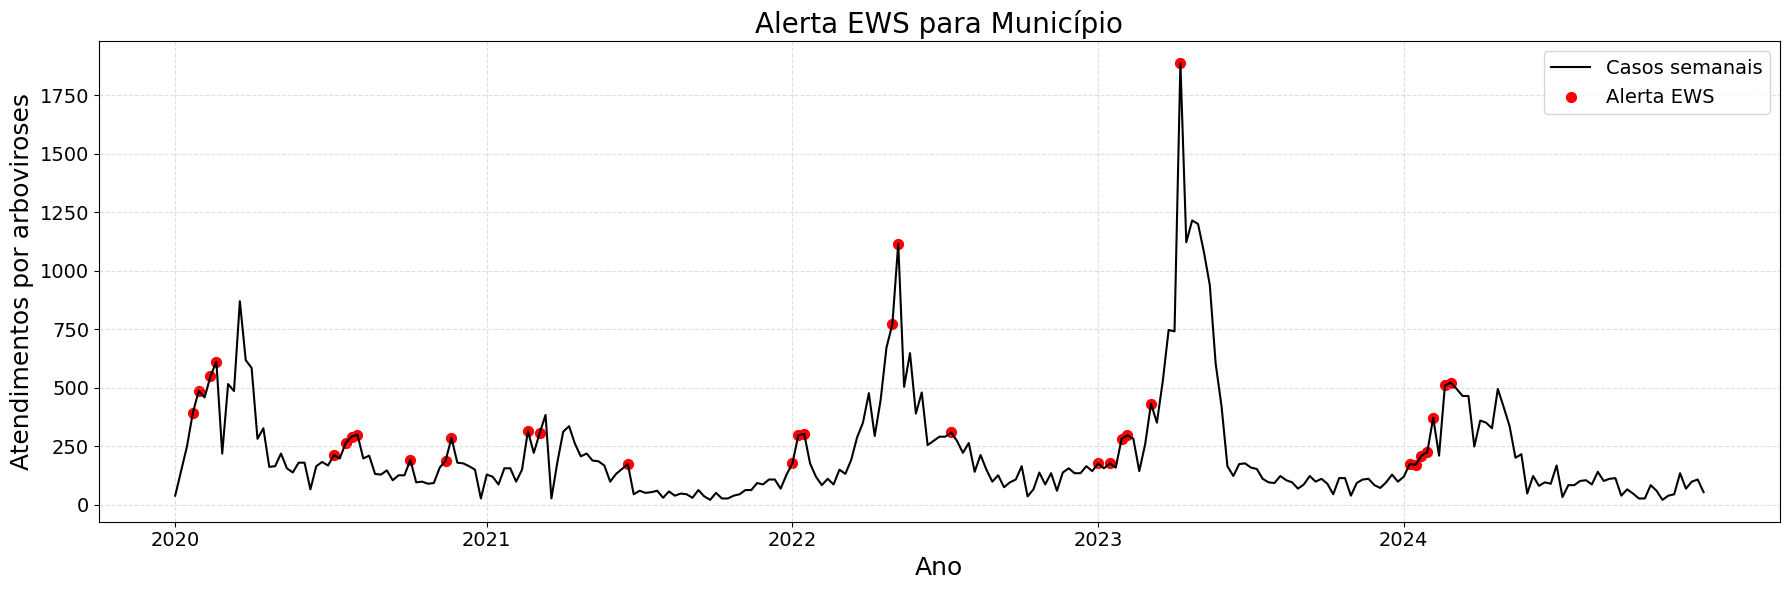

Plotando Município 510340: 261 semanas. Alertas encontrados: {'Não': 250, 'Sim': 11}


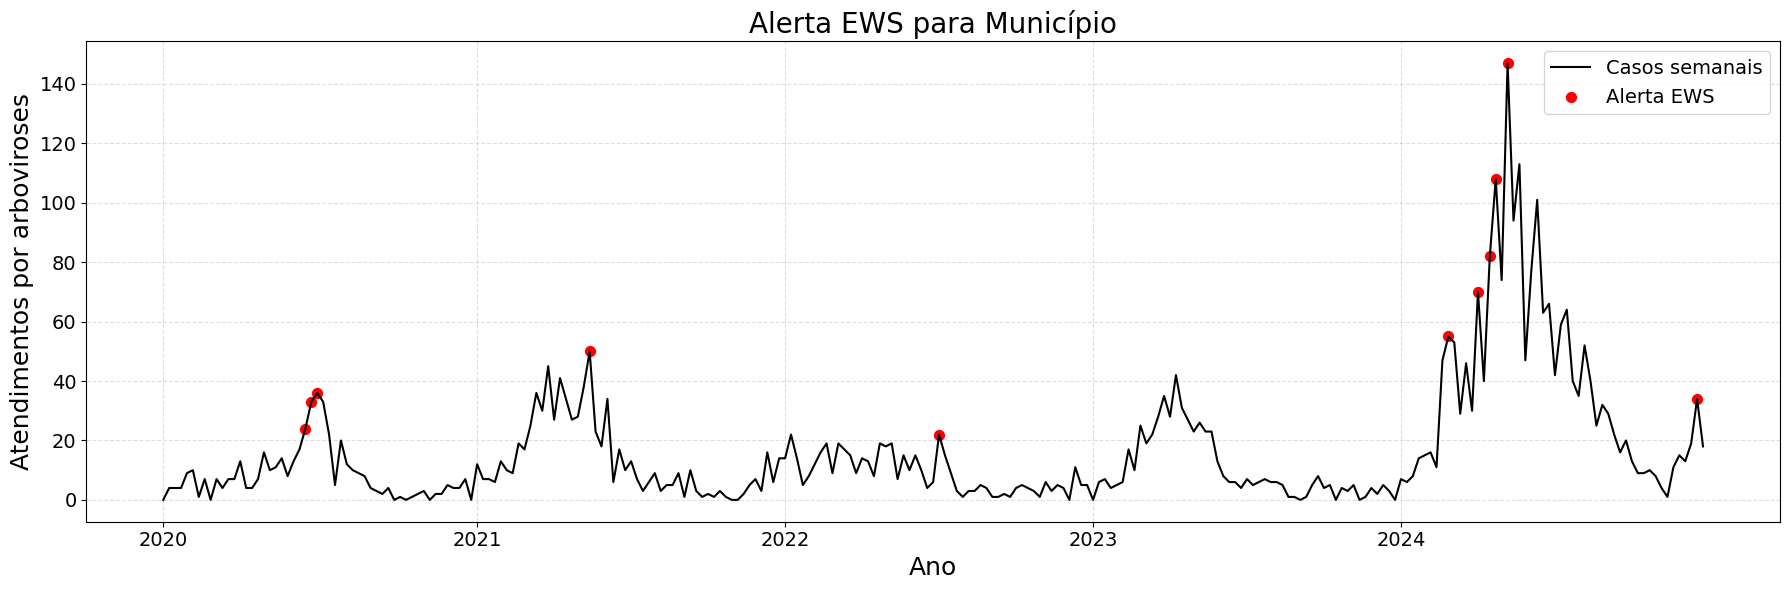

Plotando Município 150140: 261 semanas. Alertas encontrados: {'Não': 234, 'Sim': 27}


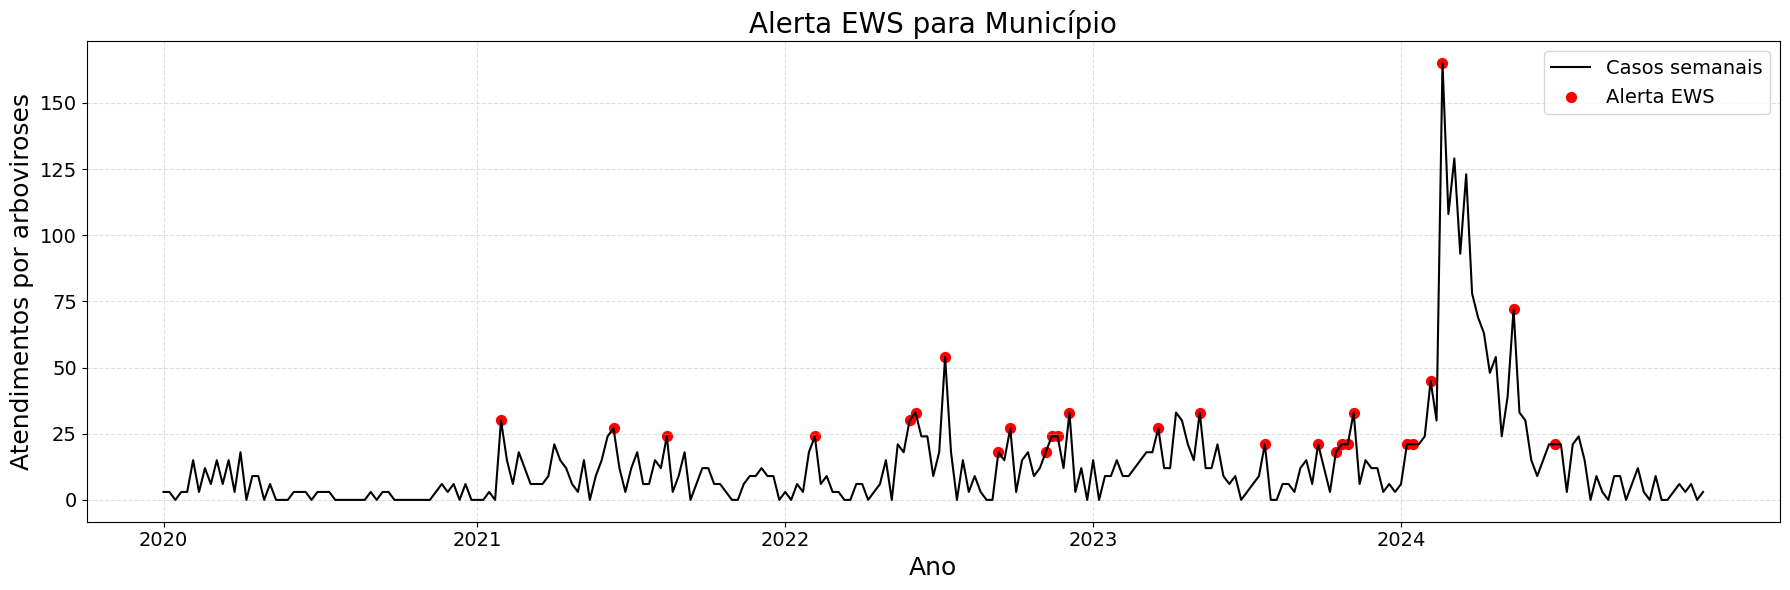

Plotando Município 250750: 261 semanas. Alertas encontrados: {'Não': 234, 'Sim': 27}


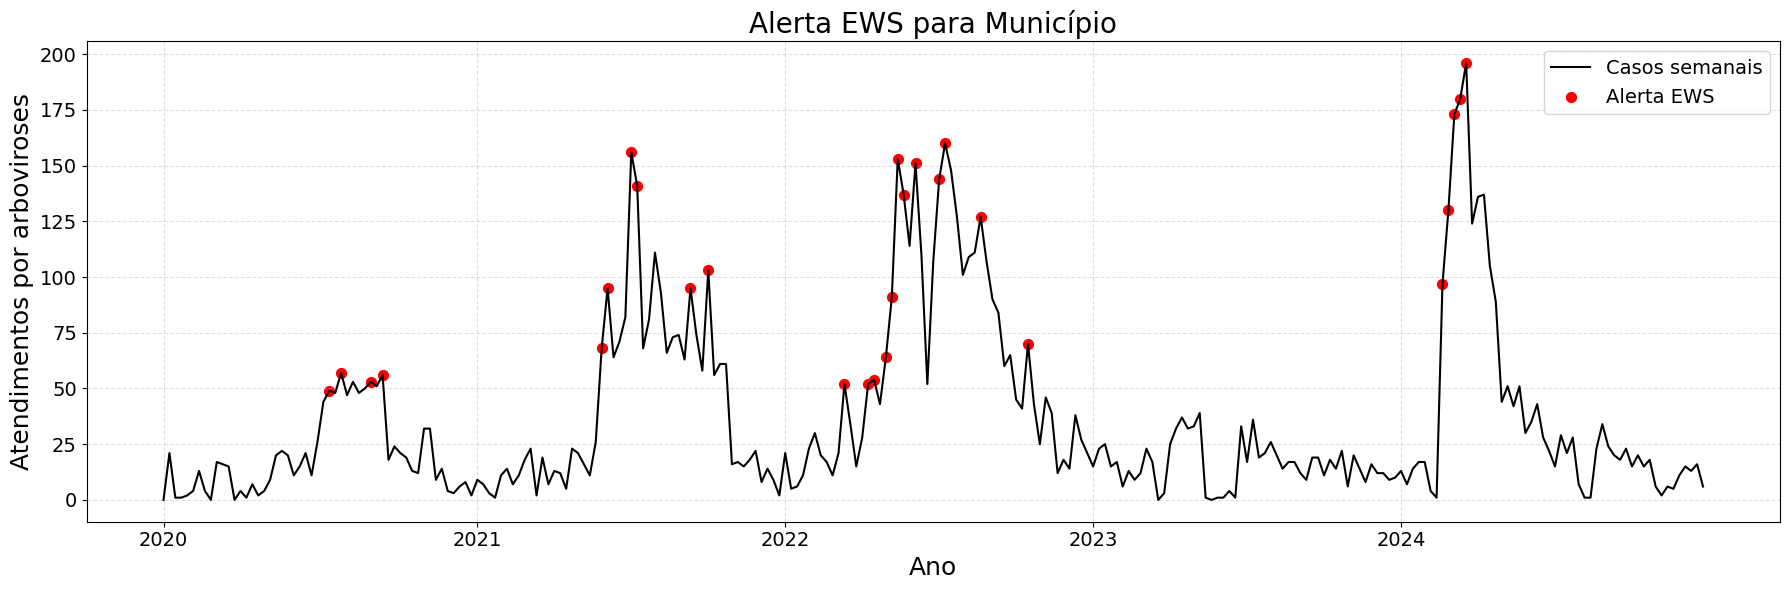

Plotando Município 261160: 261 semanas. Alertas encontrados: {'Não': 250, 'Sim': 11}


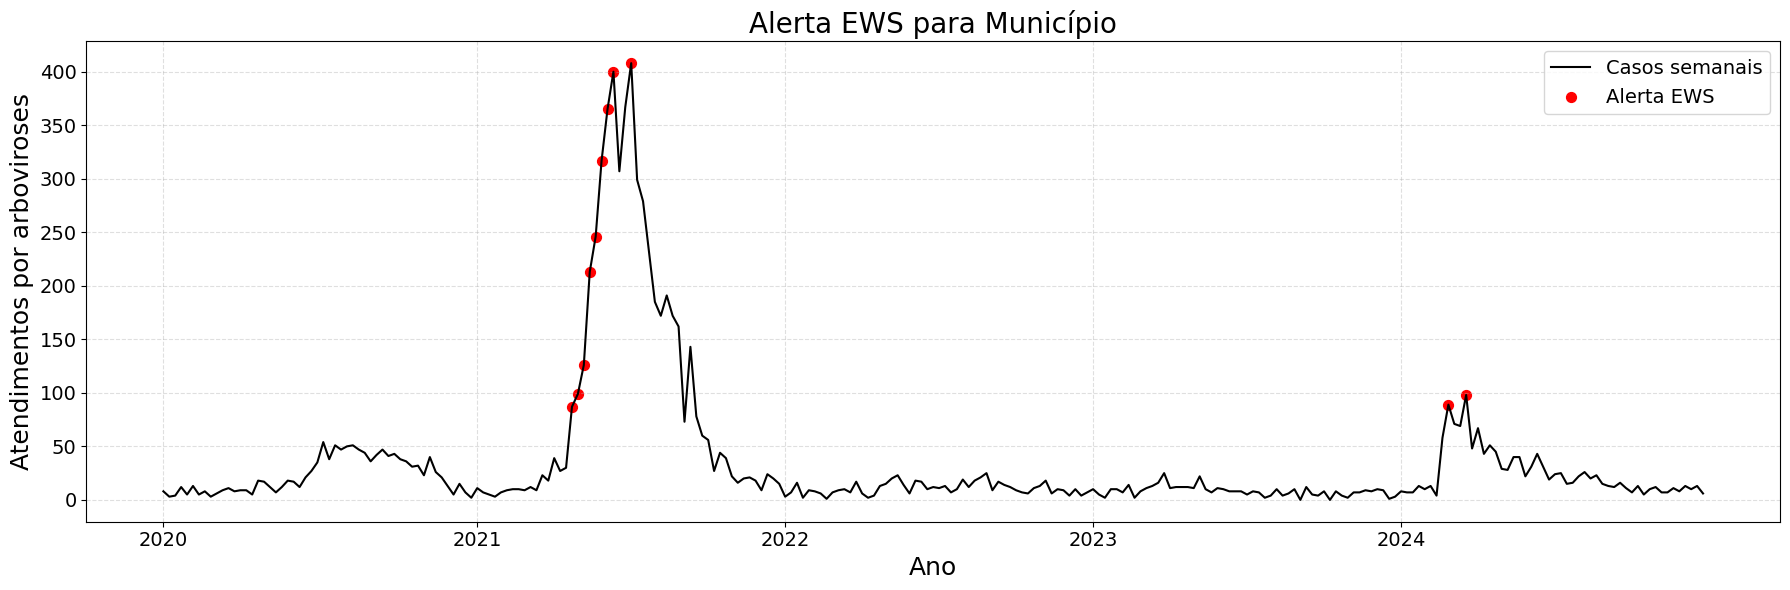

Plotando Município 221100: 261 semanas. Alertas encontrados: {'Não': 241, 'Sim': 20}


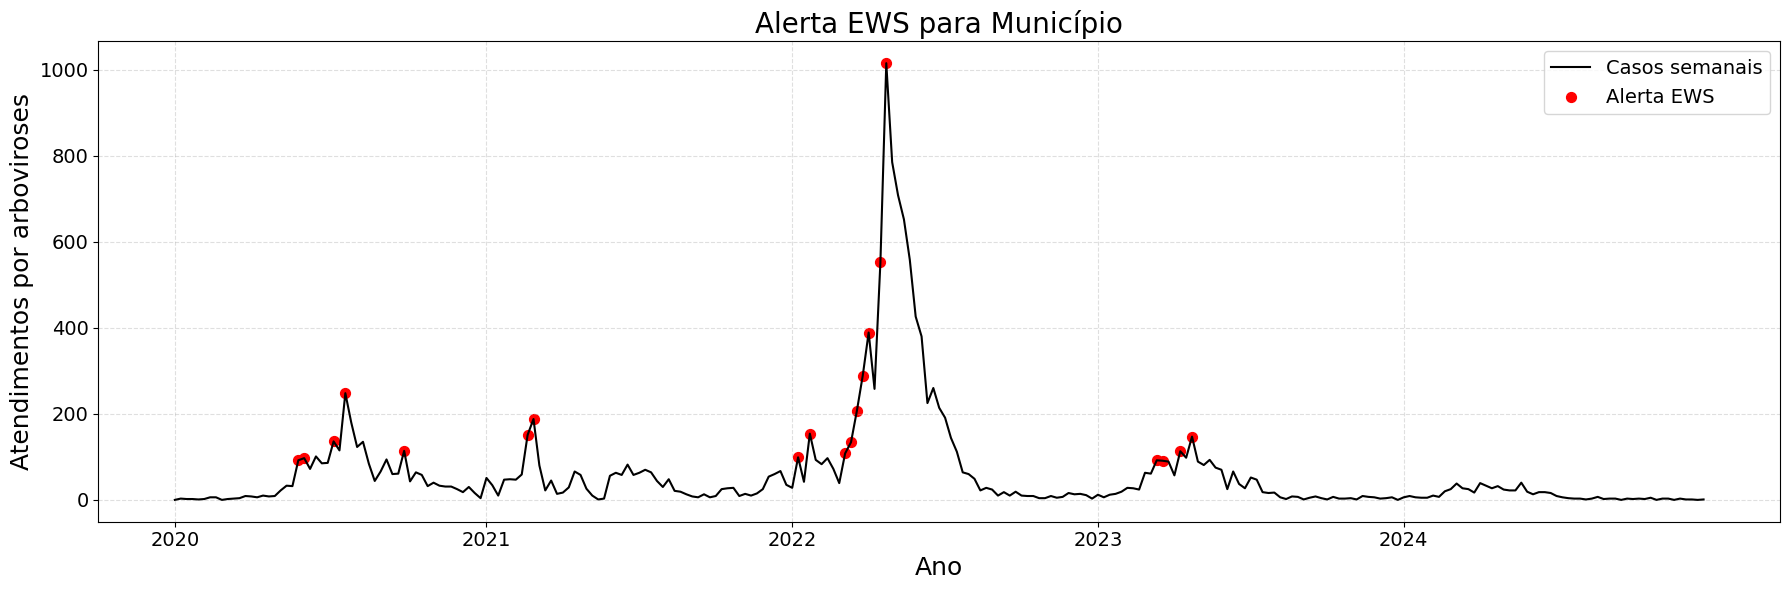

Plotando Município 410690: 261 semanas. Alertas encontrados: {'Não': 250, 'Sim': 11}


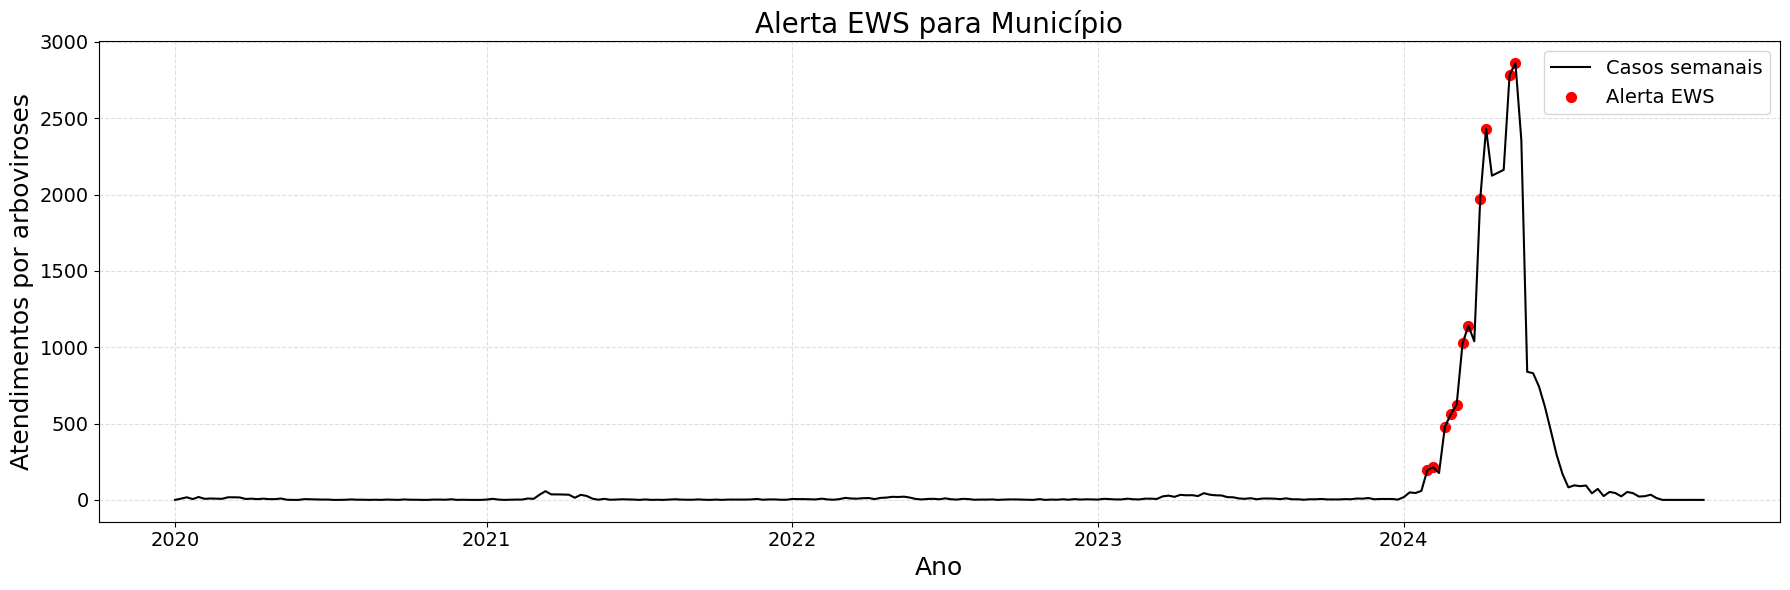

Plotando Município 330455: 261 semanas. Alertas encontrados: {'Não': 251, 'Sim': 10}


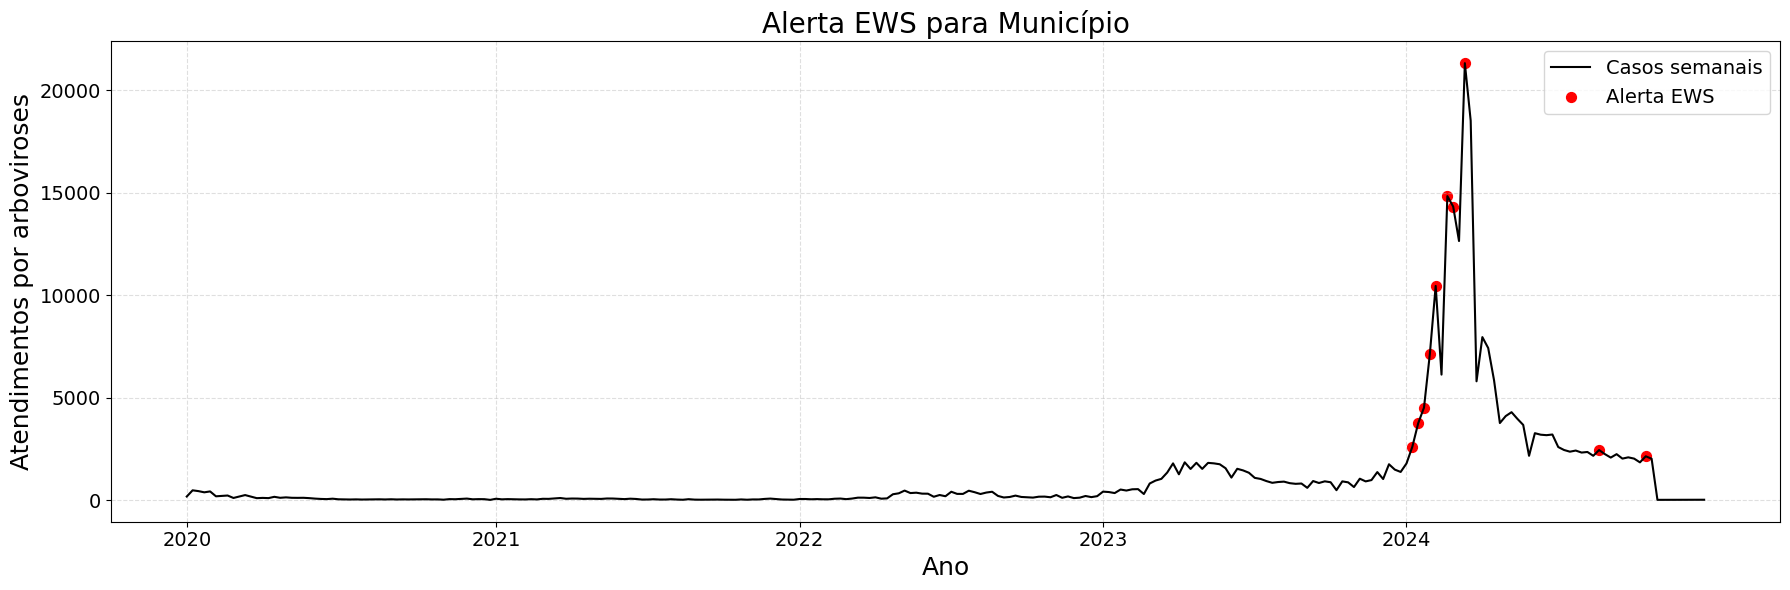

Plotando Município 240810: 261 semanas. Alertas encontrados: {'Não': 248, 'Sim': 13}


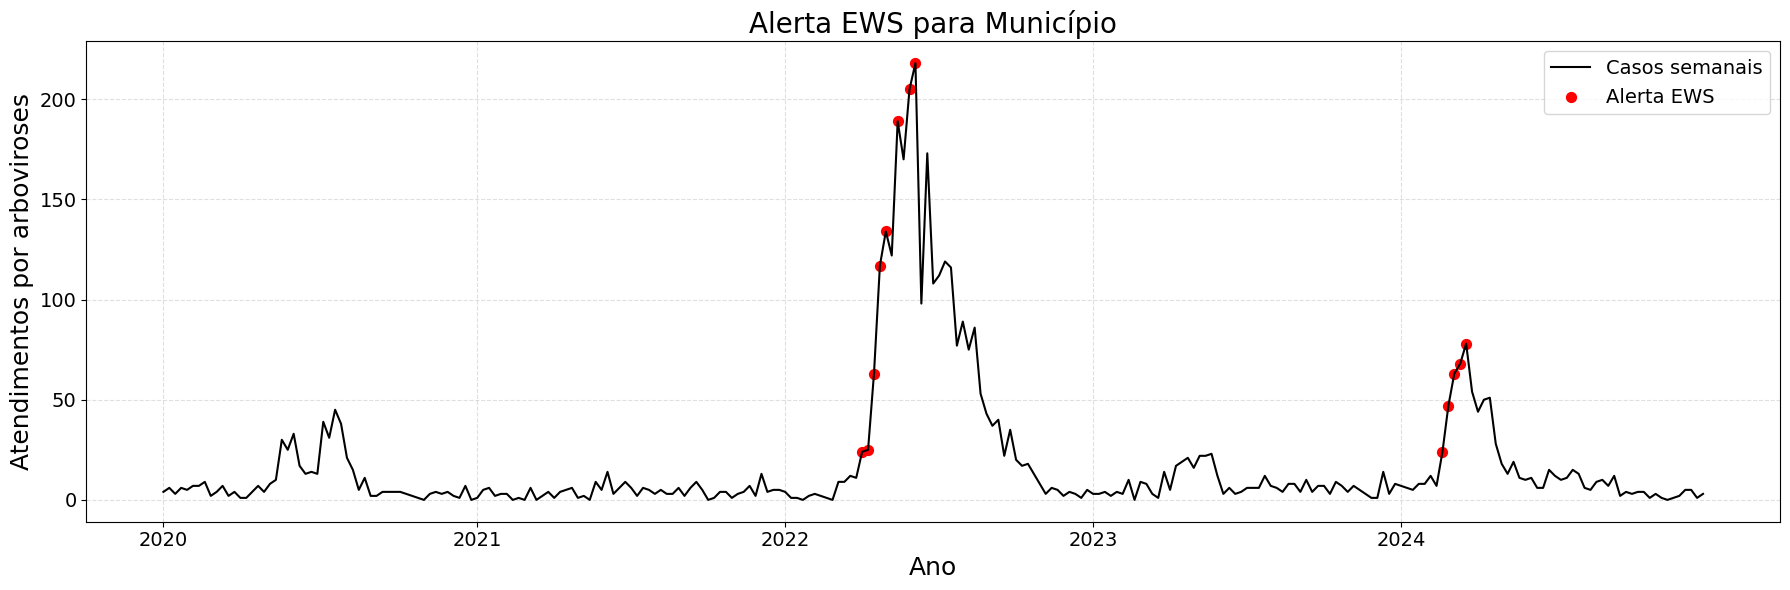

Plotando Município 110020: 261 semanas. Alertas encontrados: {'Não': 236, 'Sim': 25}


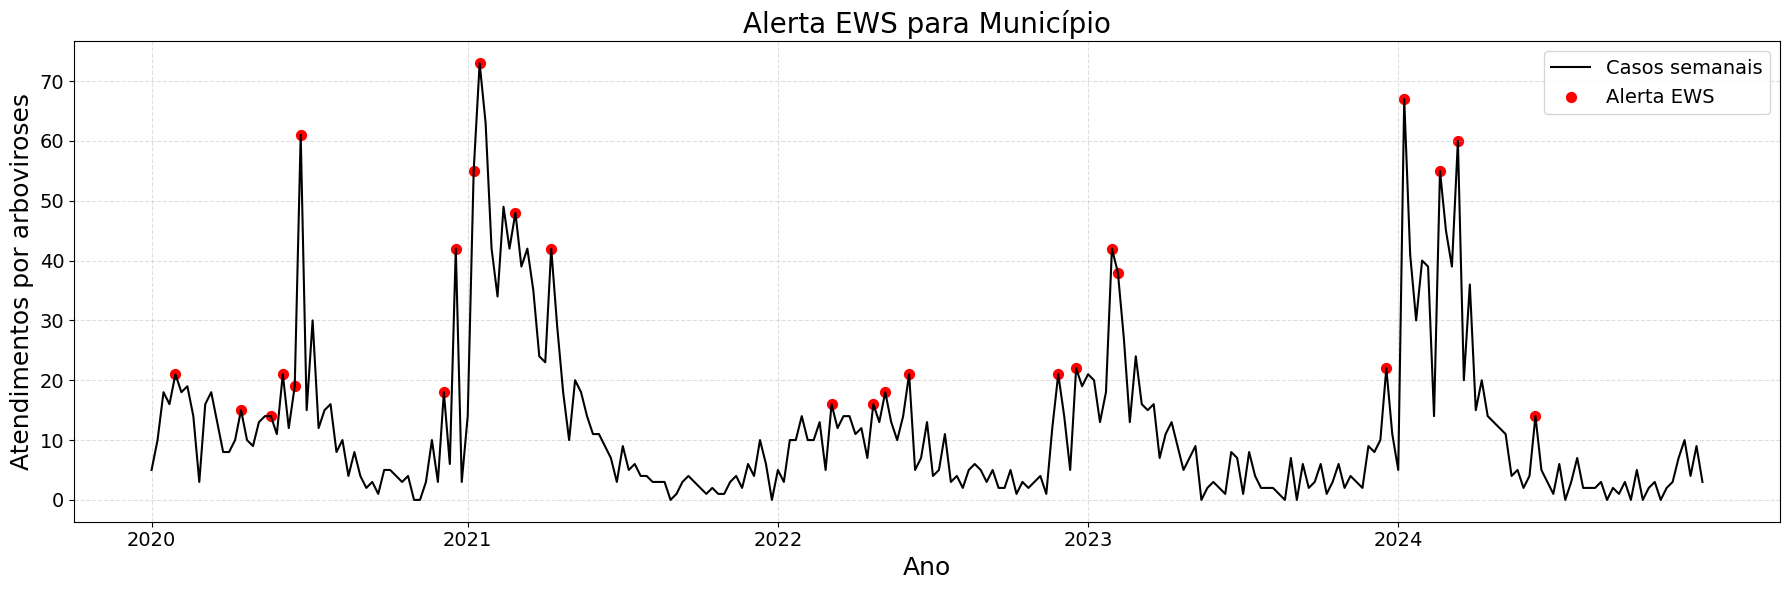

Plotando Município 140010: 261 semanas. Alertas encontrados: {'Não': 255, 'Sim': 6}


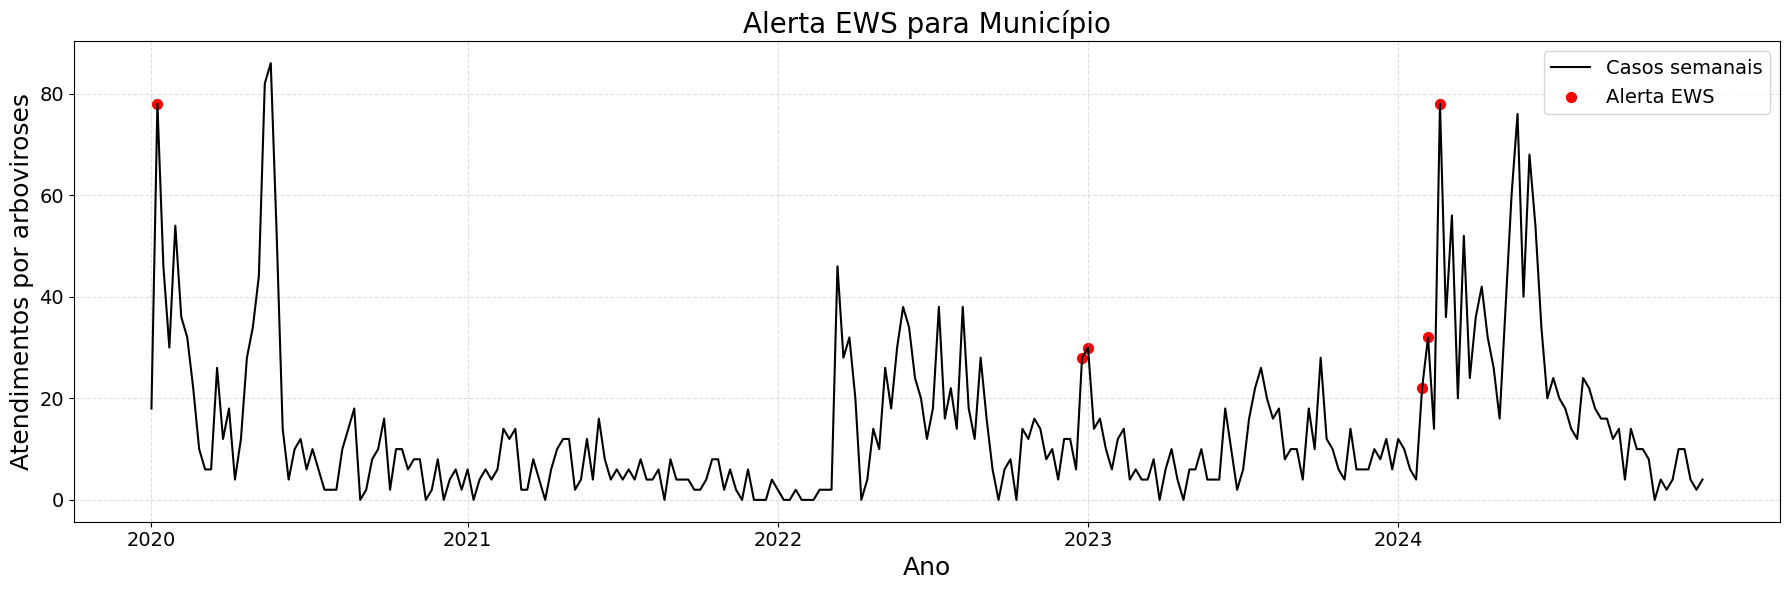

Plotando Município 431490: 261 semanas. Alertas encontrados: {'Não': 218, 'Sim': 43}


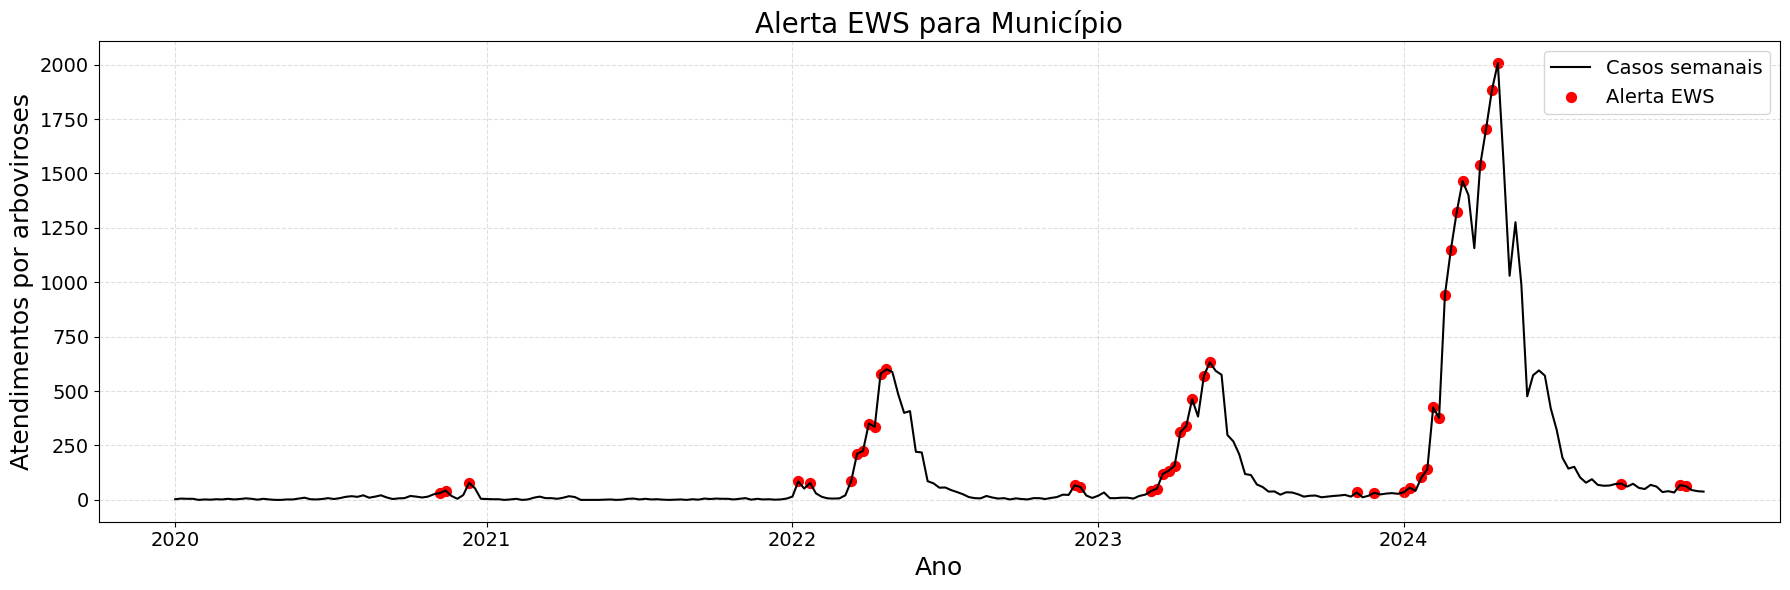

Plotando Município 420910: 261 semanas. Alertas encontrados: {'Não': 181, 'Sim': 80}


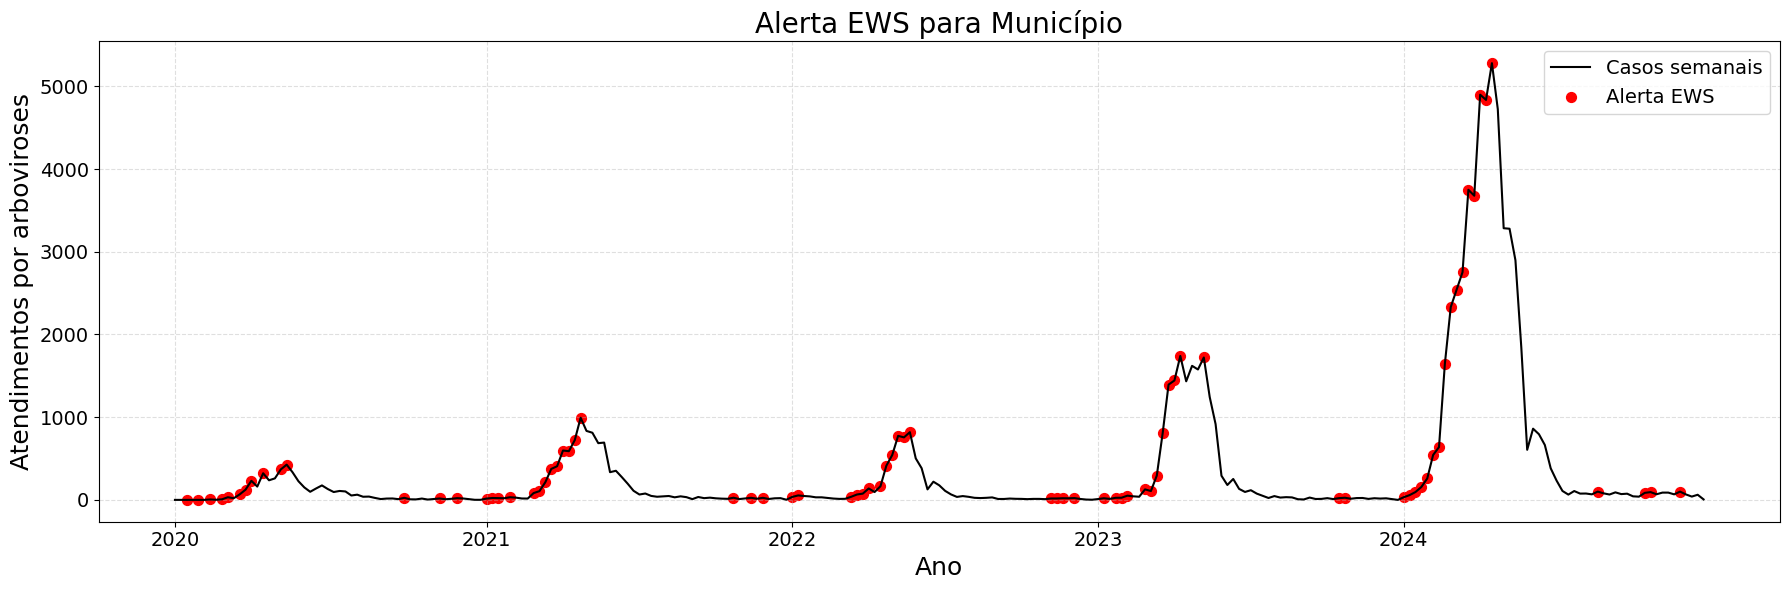

Plotando Município 280030: 261 semanas. Alertas encontrados: {'Não': 222, 'Sim': 39}


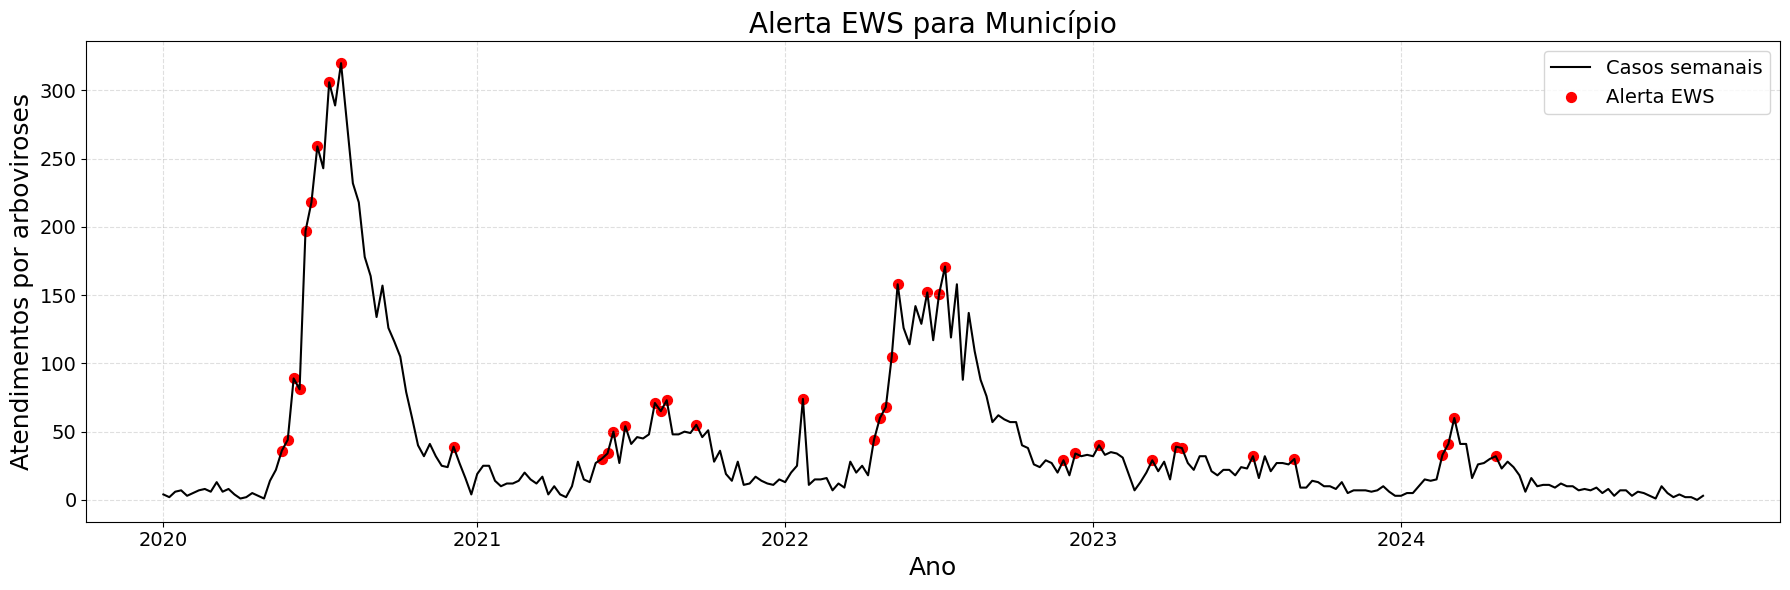

Plotando Município 355030: 261 semanas. Alertas encontrados: {'Não': 250, 'Sim': 11}


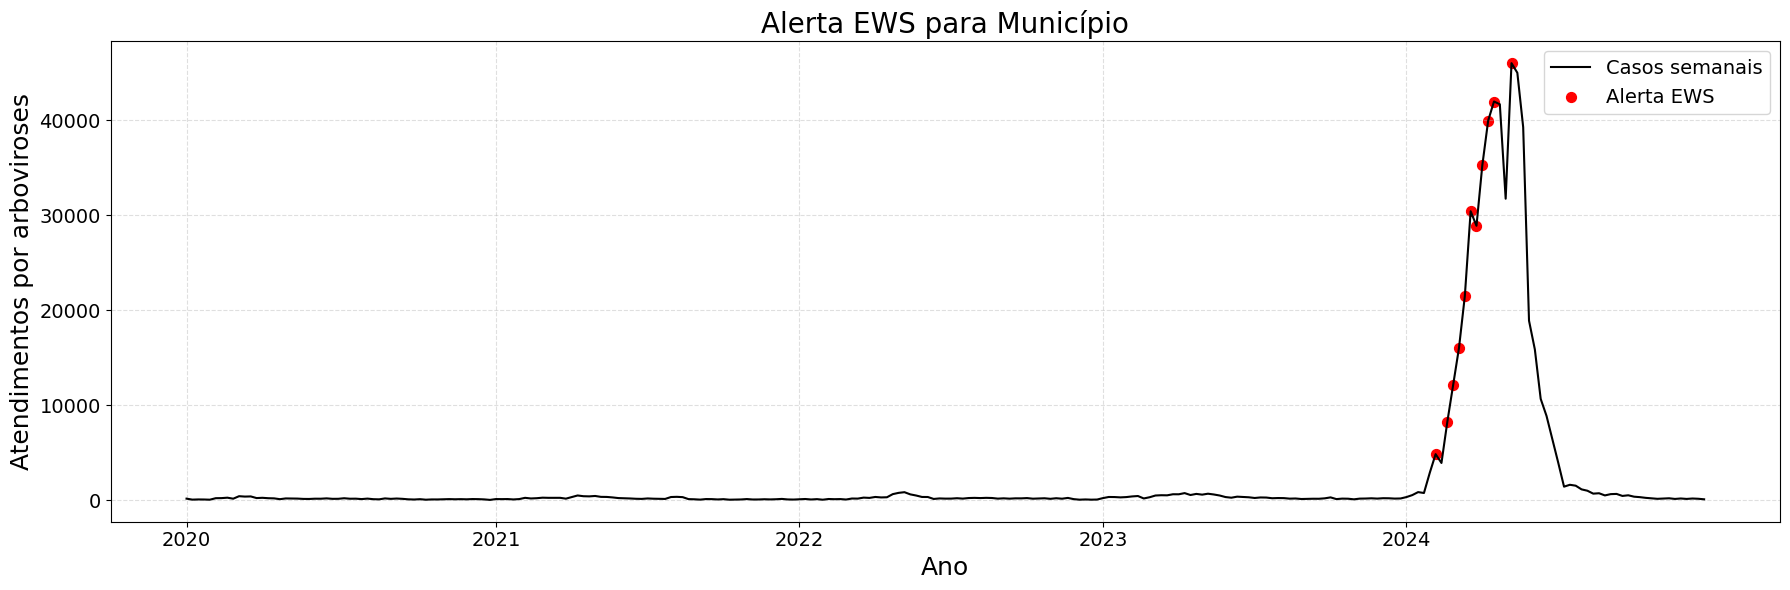

Plotando Município 172100: 261 semanas. Alertas encontrados: {'Não': 241, 'Sim': 20}


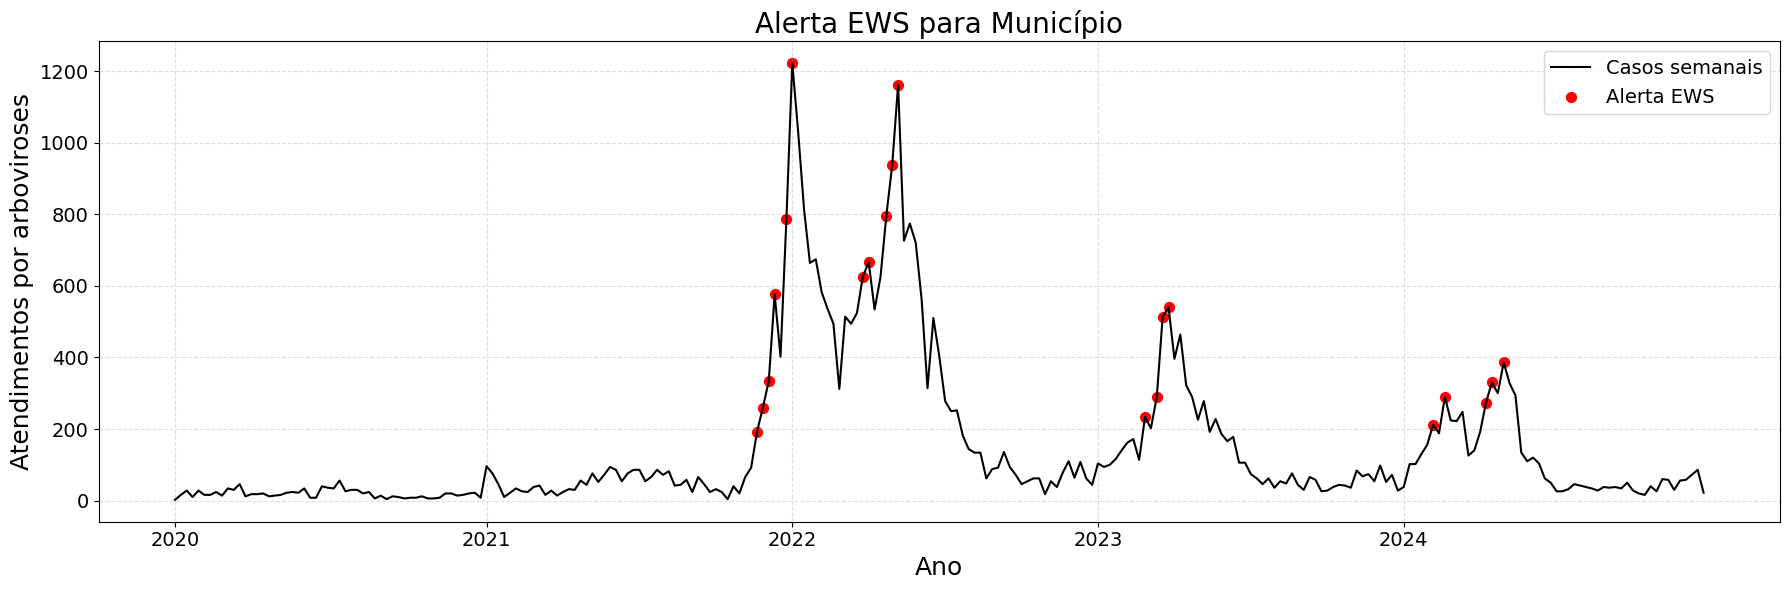

In [75]:
#result_final = pd.read_csv('resultados/EWS_mun_completed_padrao.csv', sep=';')

for cod_ibge in lista_capitais:

    plot_alerta_mun(result_final, cod_ibge, title='Alerta EWS para Município')

Plotando Município 120040: 261 semanas. Alertas encontrados: {'Não': 242, 'Sim': 19}


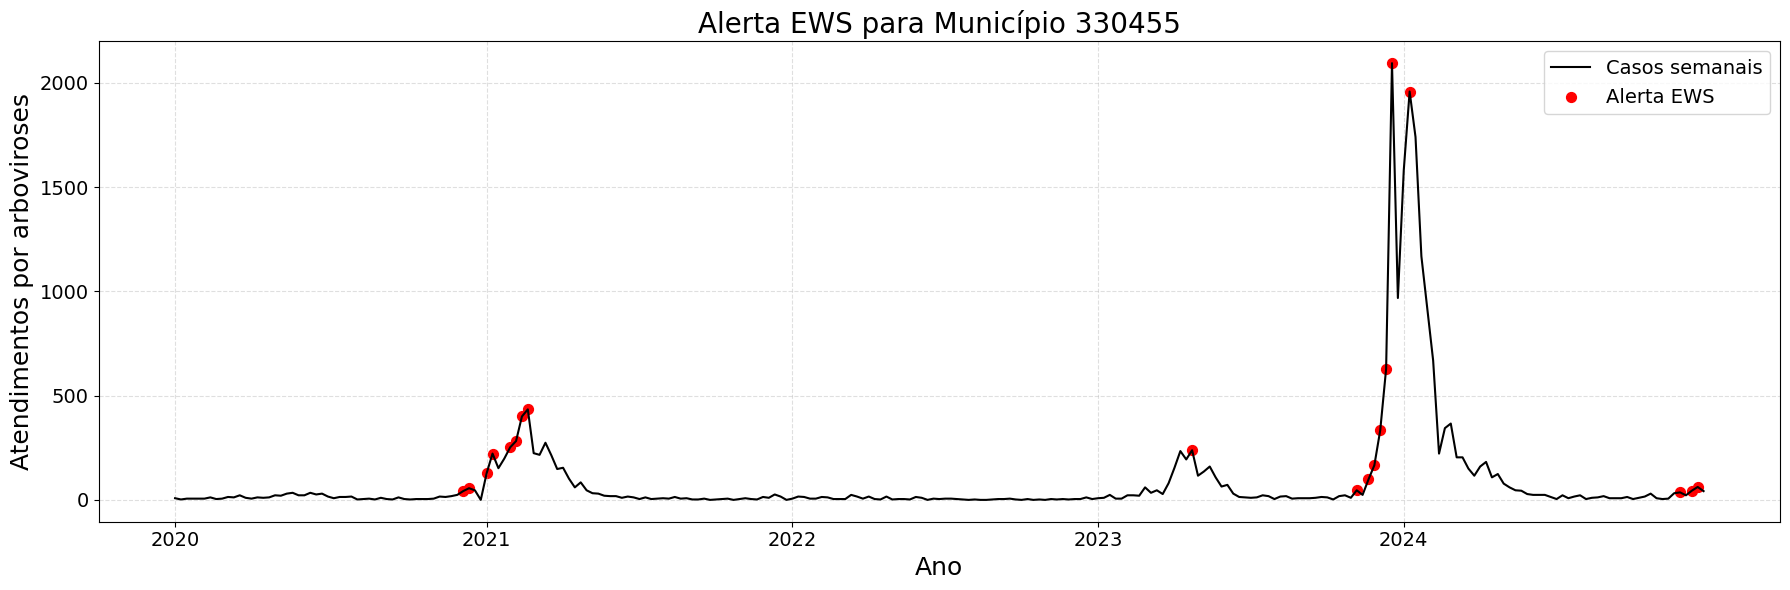

Plotando Município 270430: 261 semanas. Alertas encontrados: {'Não': 234, 'Sim': 27}


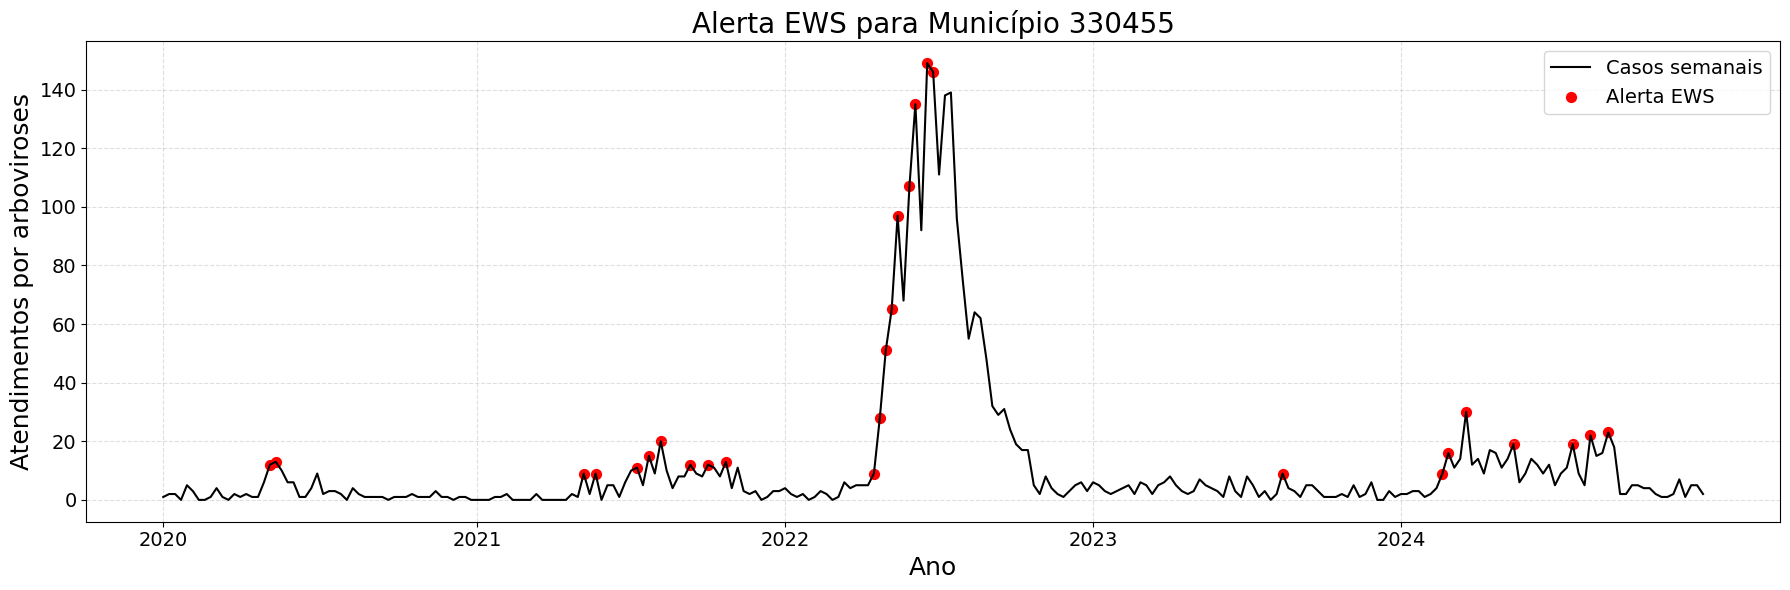

Plotando Município 130260: 261 semanas. Alertas encontrados: {'Não': 209, 'Sim': 52}


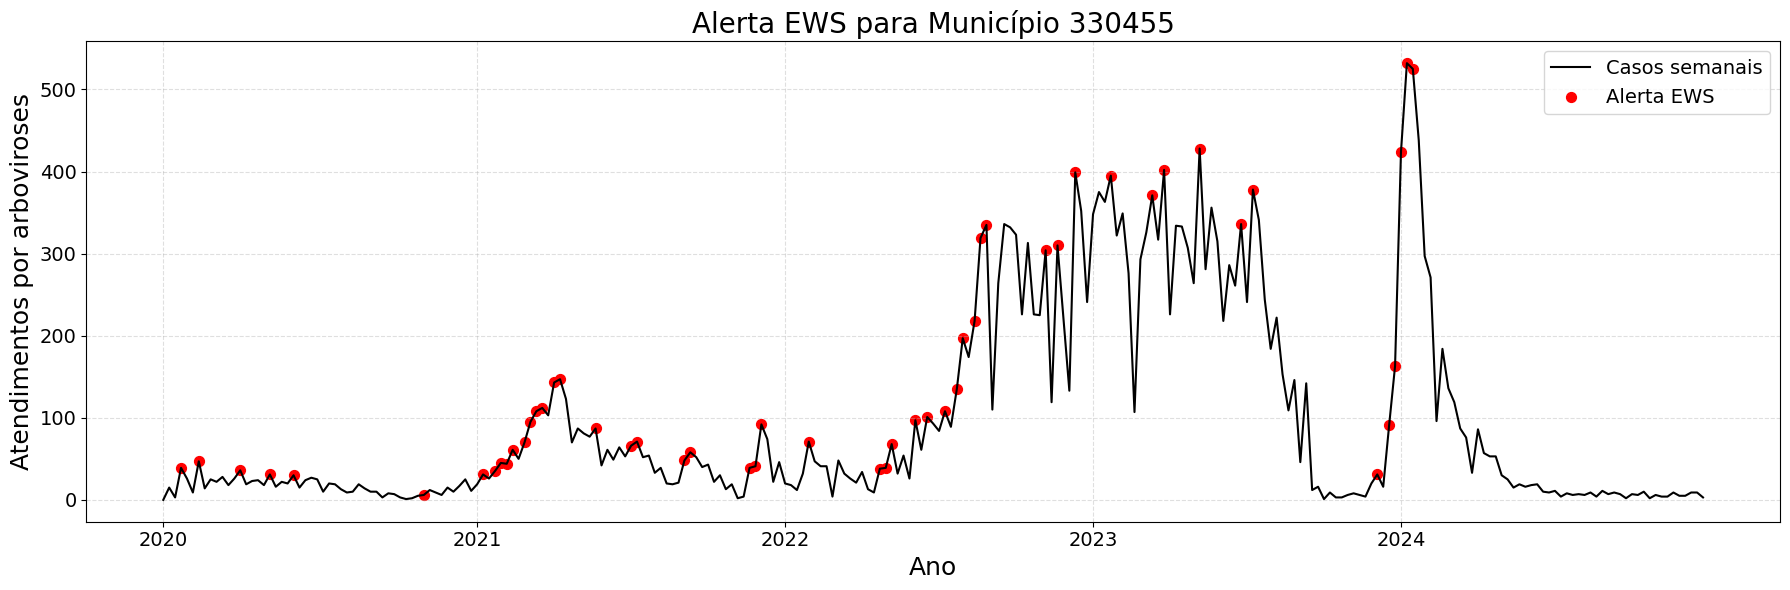

Plotando Município 160030: 261 semanas. Alertas encontrados: {'Não': 228, 'Sim': 33}


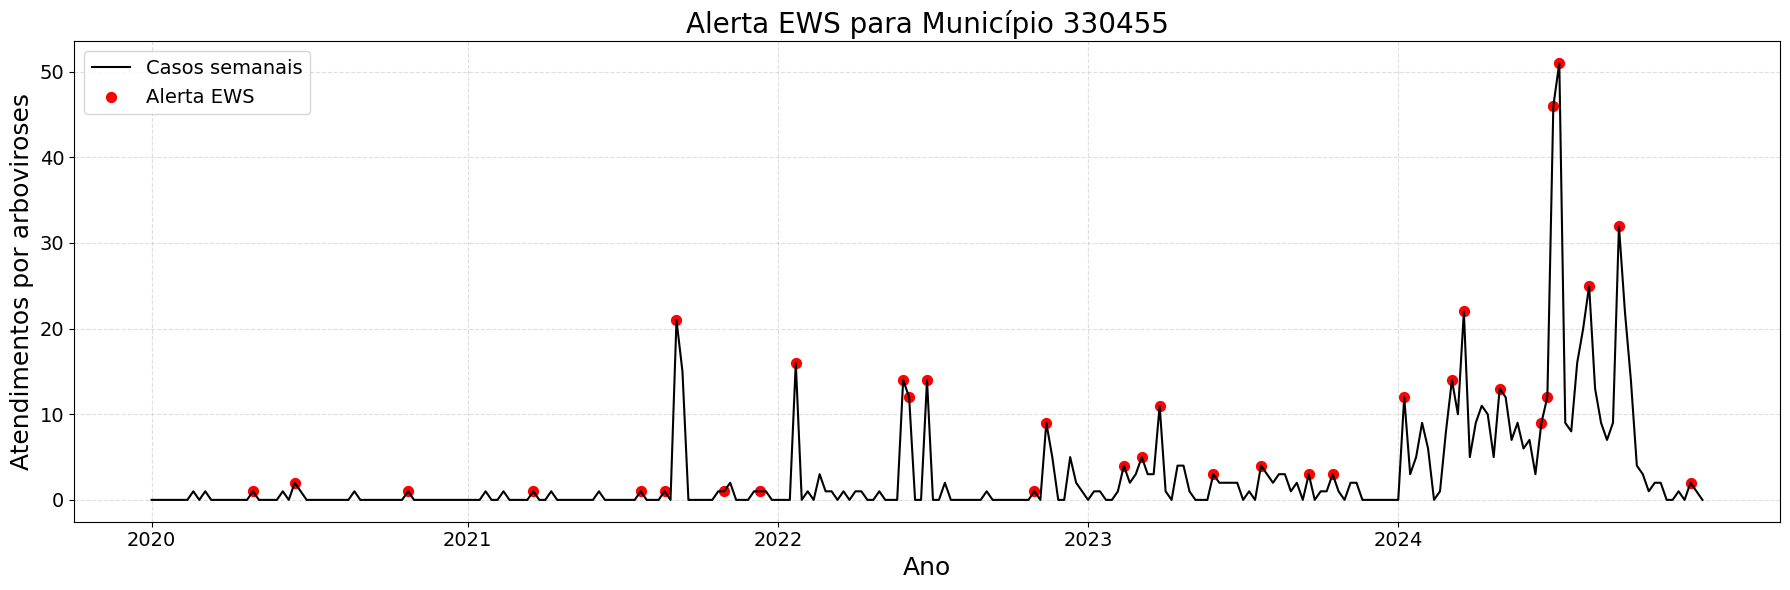

Plotando Município 292740: 261 semanas. Alertas encontrados: {'Não': 244, 'Sim': 17}


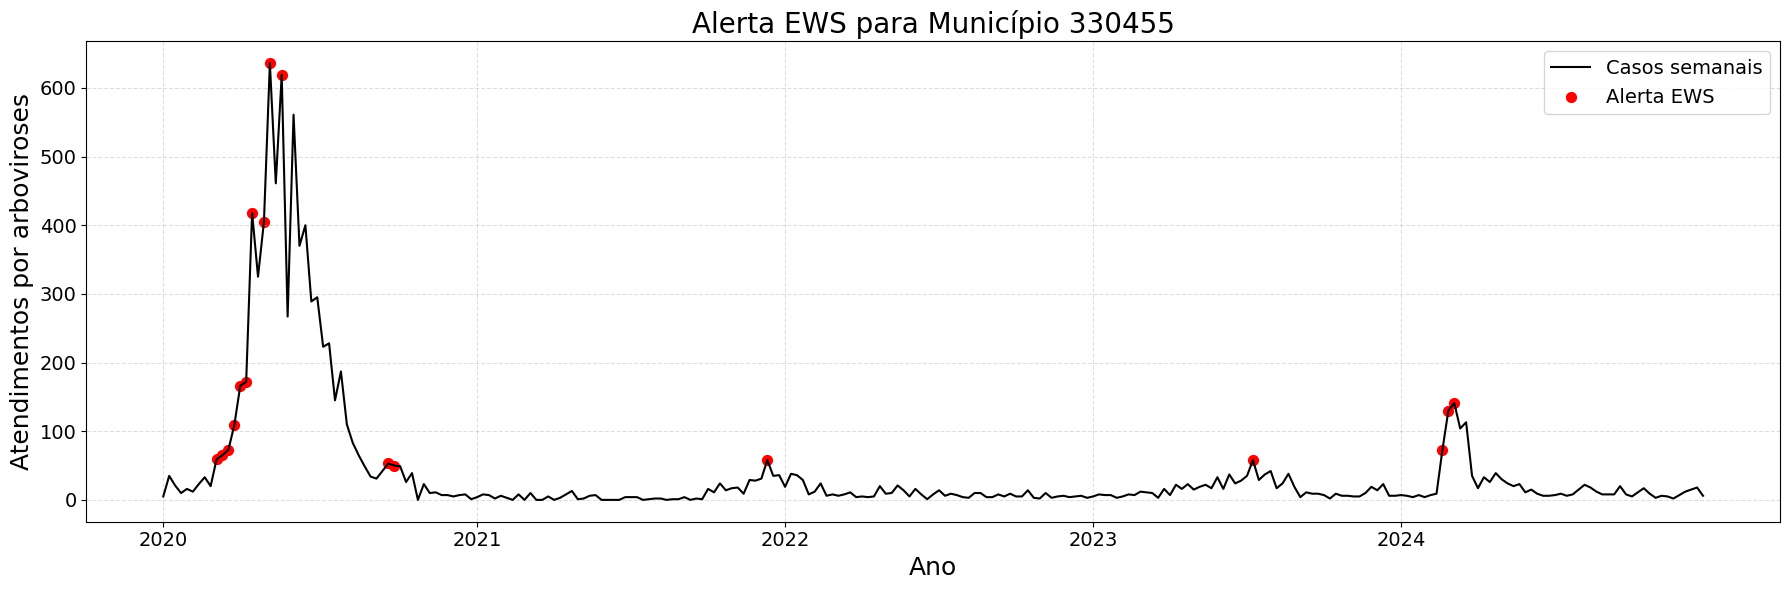

Plotando Município 230440: 261 semanas. Alertas encontrados: {'Não': 256, 'Sim': 5}


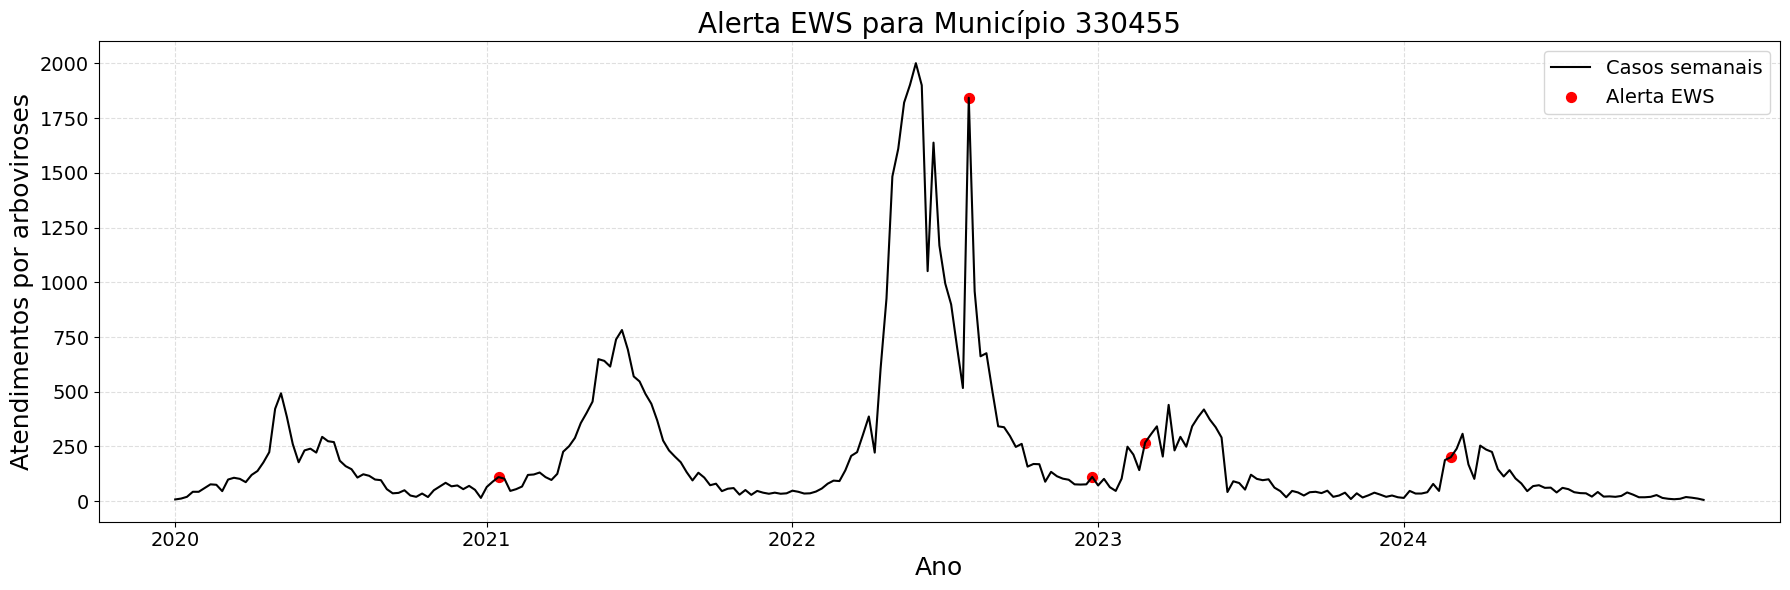

Plotando Município 530010: 261 semanas. Alertas encontrados: {'Não': 220, 'Sim': 41}


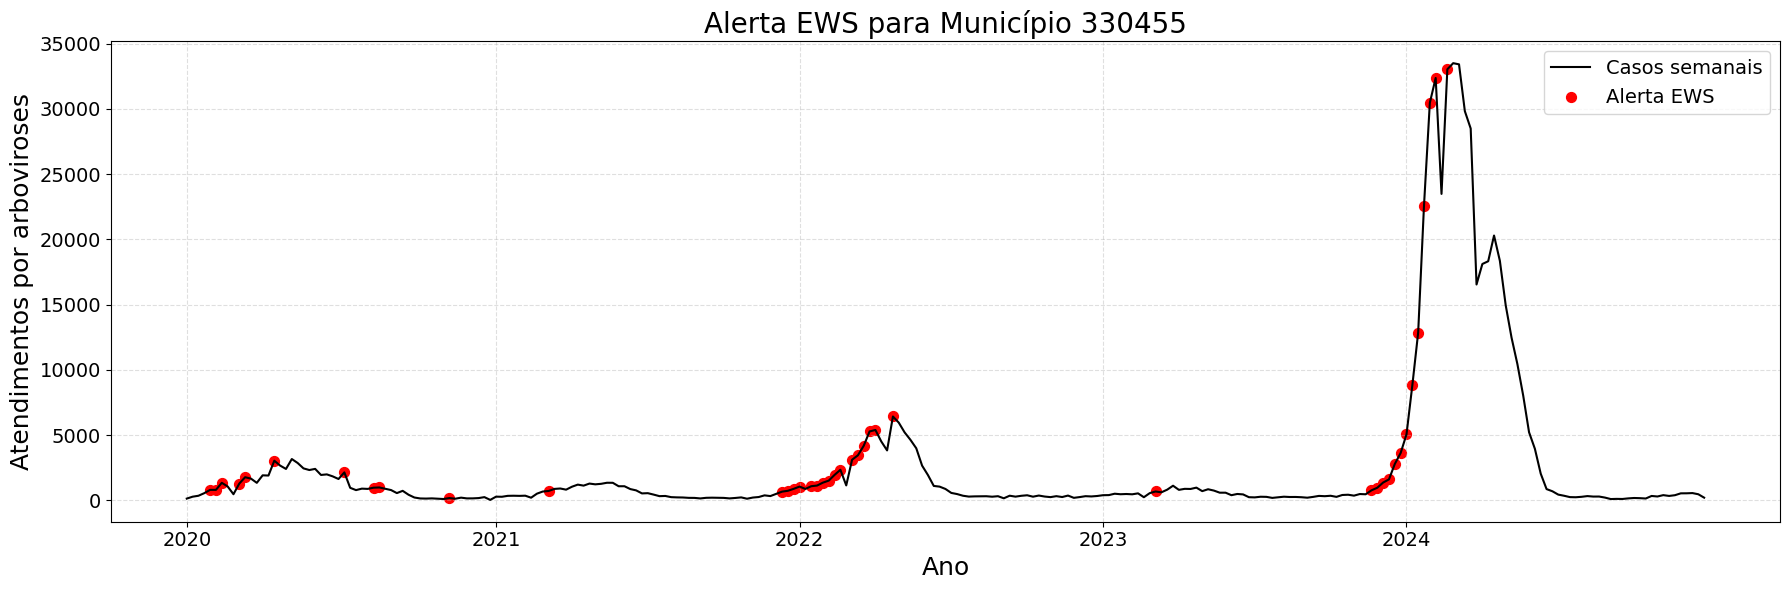

Plotando Município 320530: 261 semanas. Alertas encontrados: {'Não': 238, 'Sim': 23}


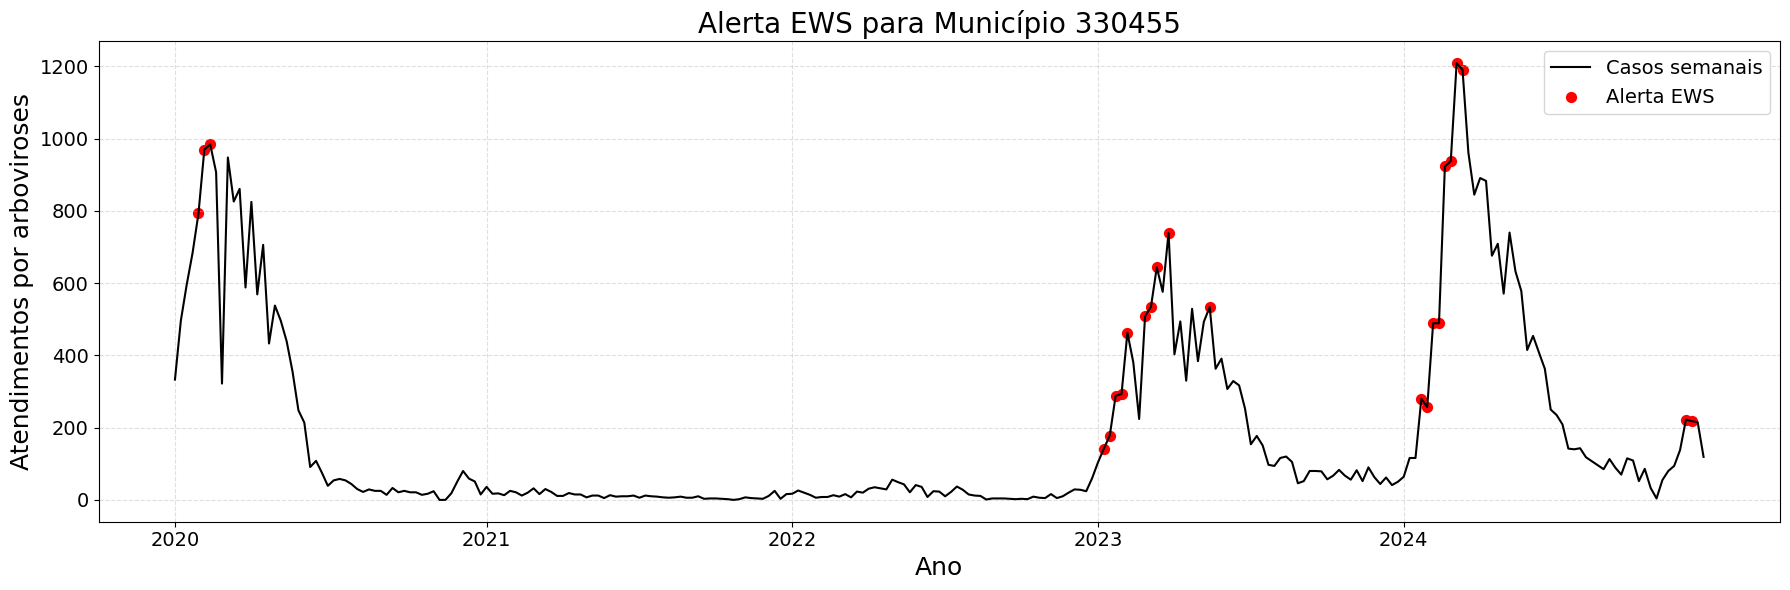

Plotando Município 520870: 261 semanas. Alertas encontrados: {'Não': 239, 'Sim': 22}


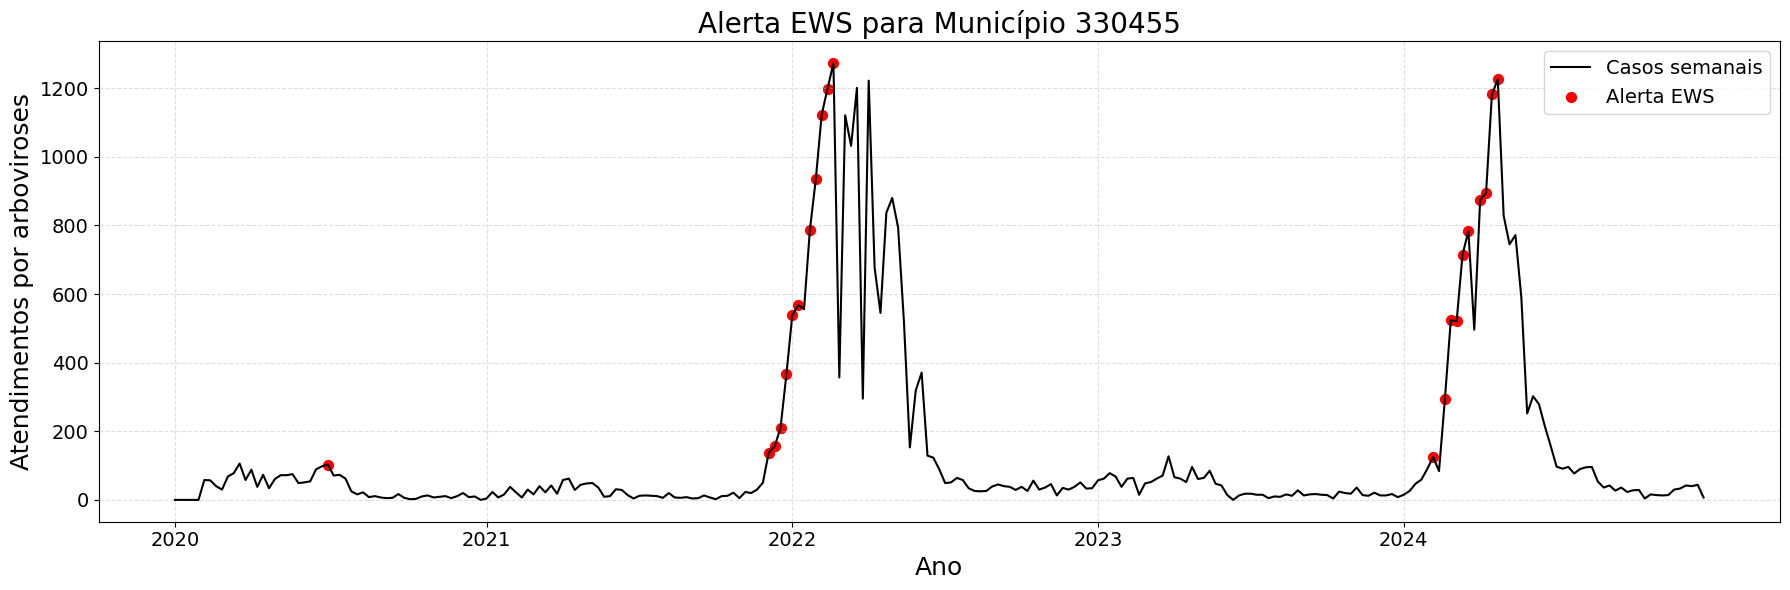

Plotando Município 211130: 261 semanas. Alertas encontrados: {'Não': 213, 'Sim': 48}


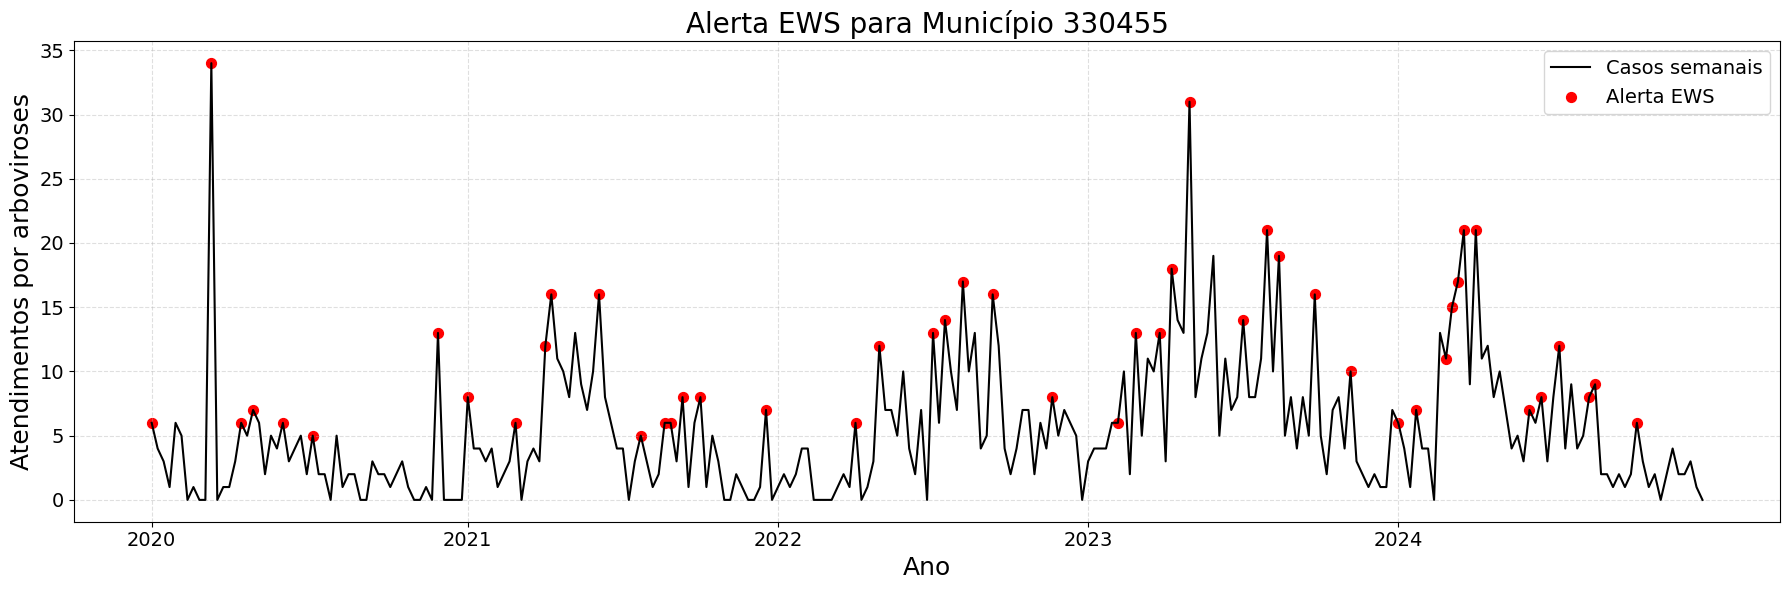

Plotando Município 310620: 261 semanas. Alertas encontrados: {'Não': 234, 'Sim': 27}


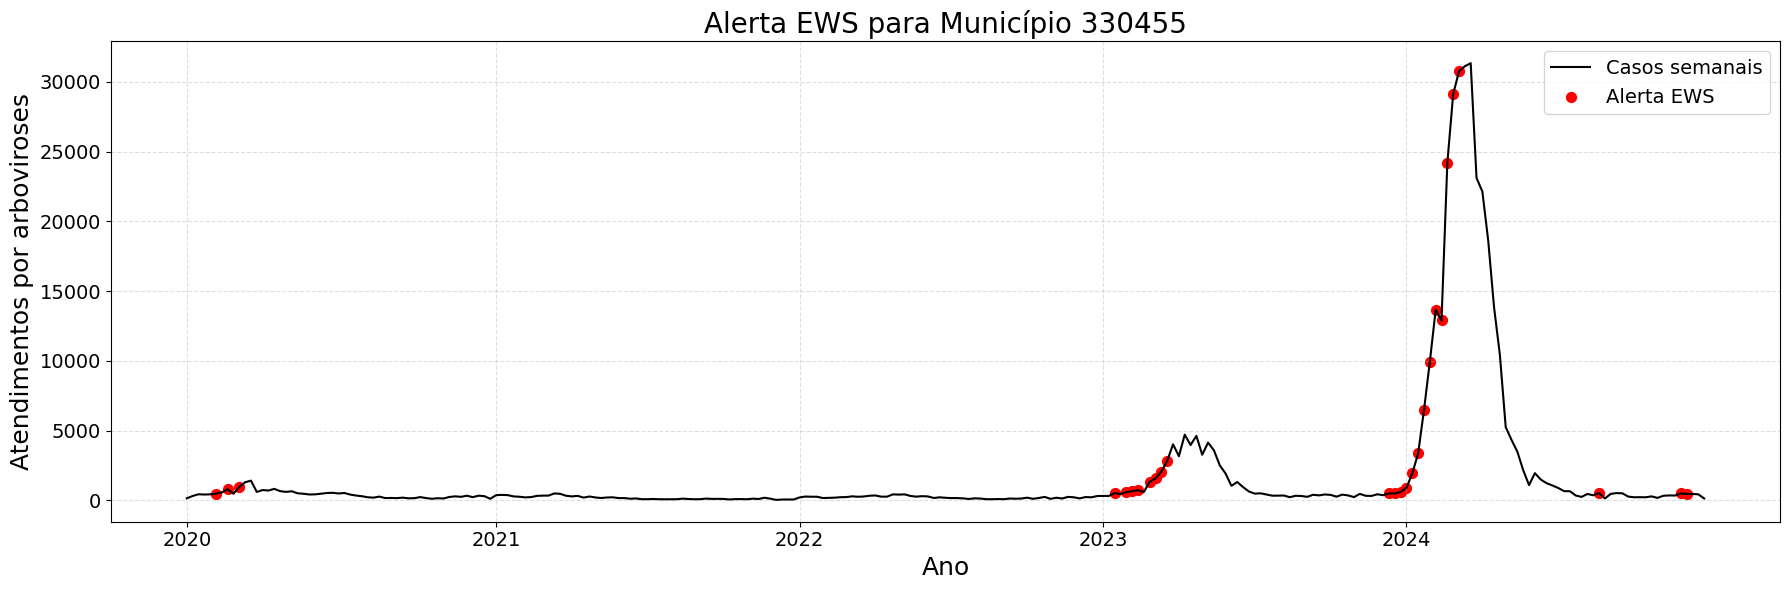

Plotando Município 500270: 261 semanas. Alertas encontrados: {'Não': 217, 'Sim': 44}


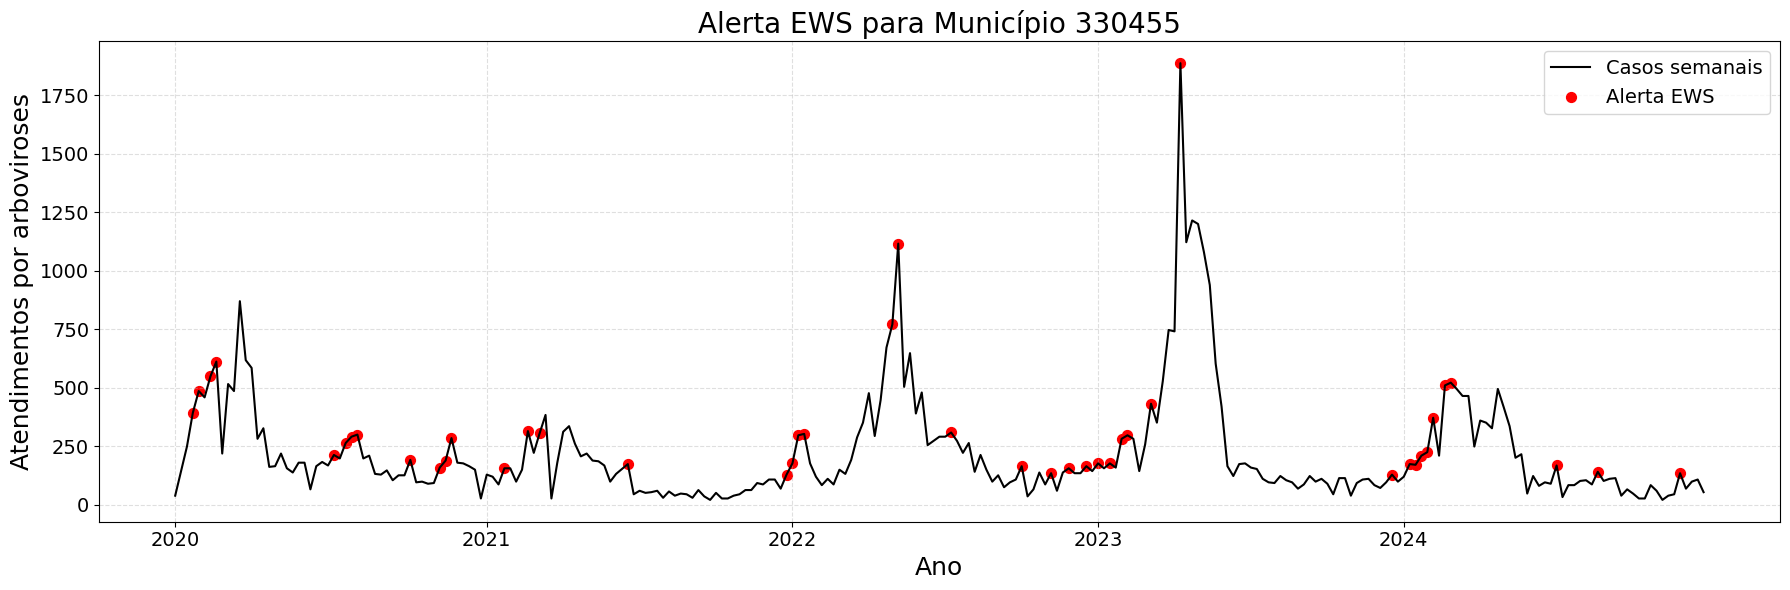

Plotando Município 510340: 261 semanas. Alertas encontrados: {'Não': 244, 'Sim': 17}


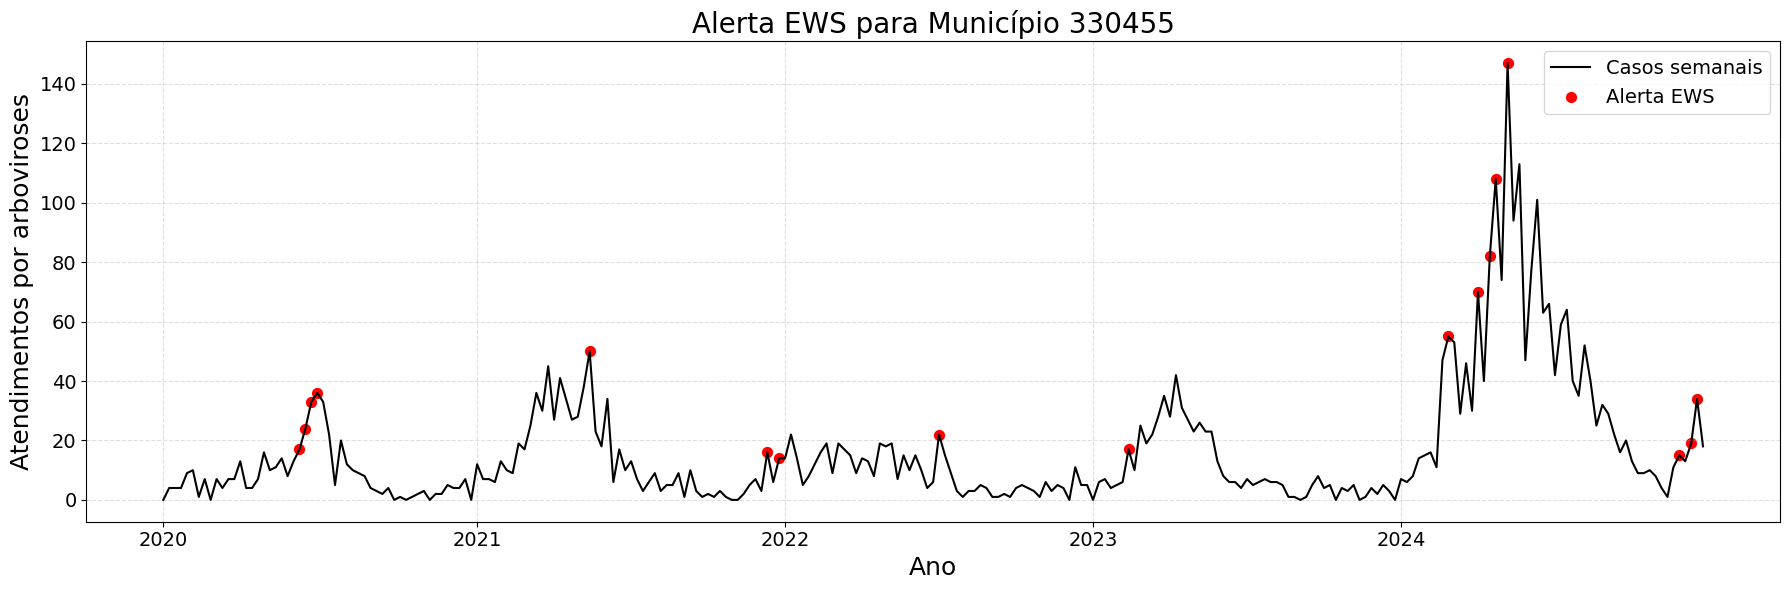

Plotando Município 150140: 261 semanas. Alertas encontrados: {'Não': 234, 'Sim': 27}


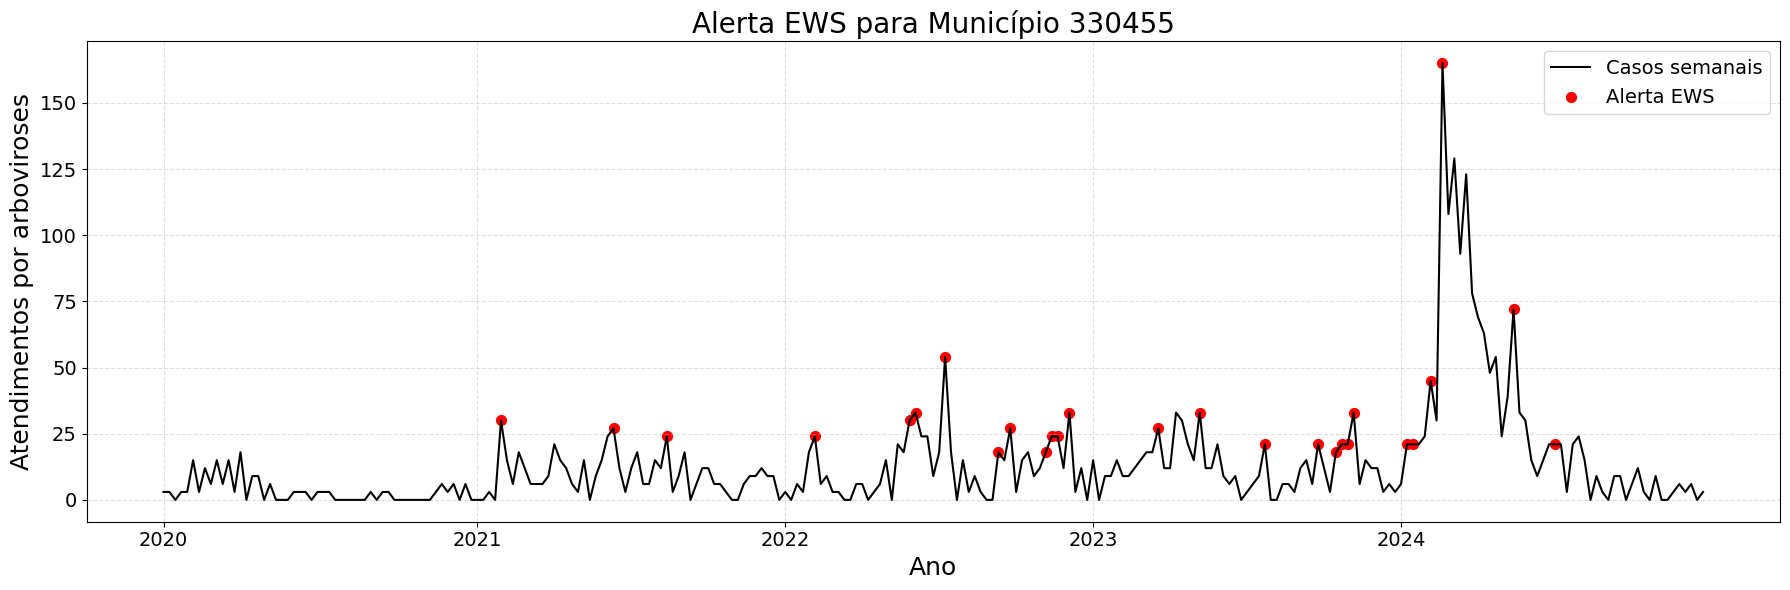

Plotando Município 250750: 261 semanas. Alertas encontrados: {'Não': 228, 'Sim': 33}


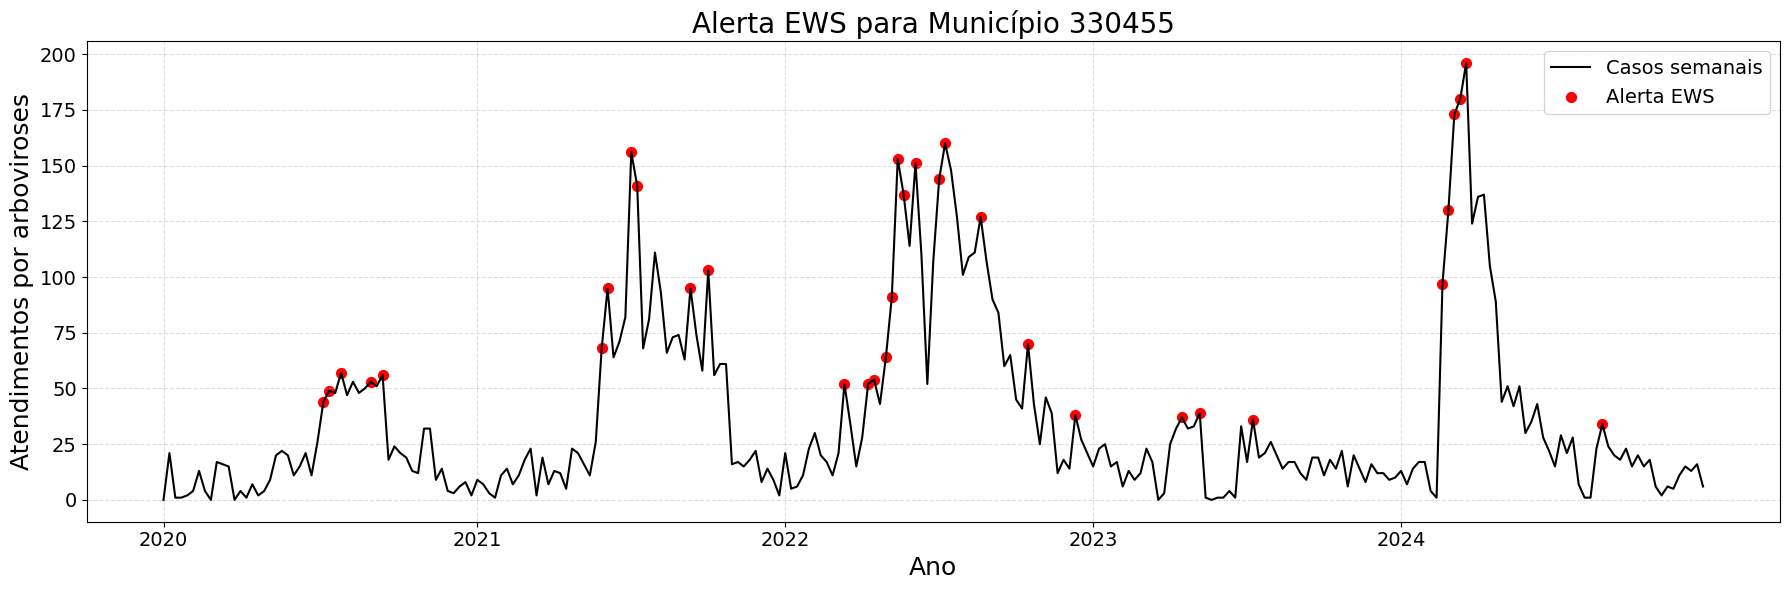

Plotando Município 261160: 261 semanas. Alertas encontrados: {'Não': 250, 'Sim': 11}


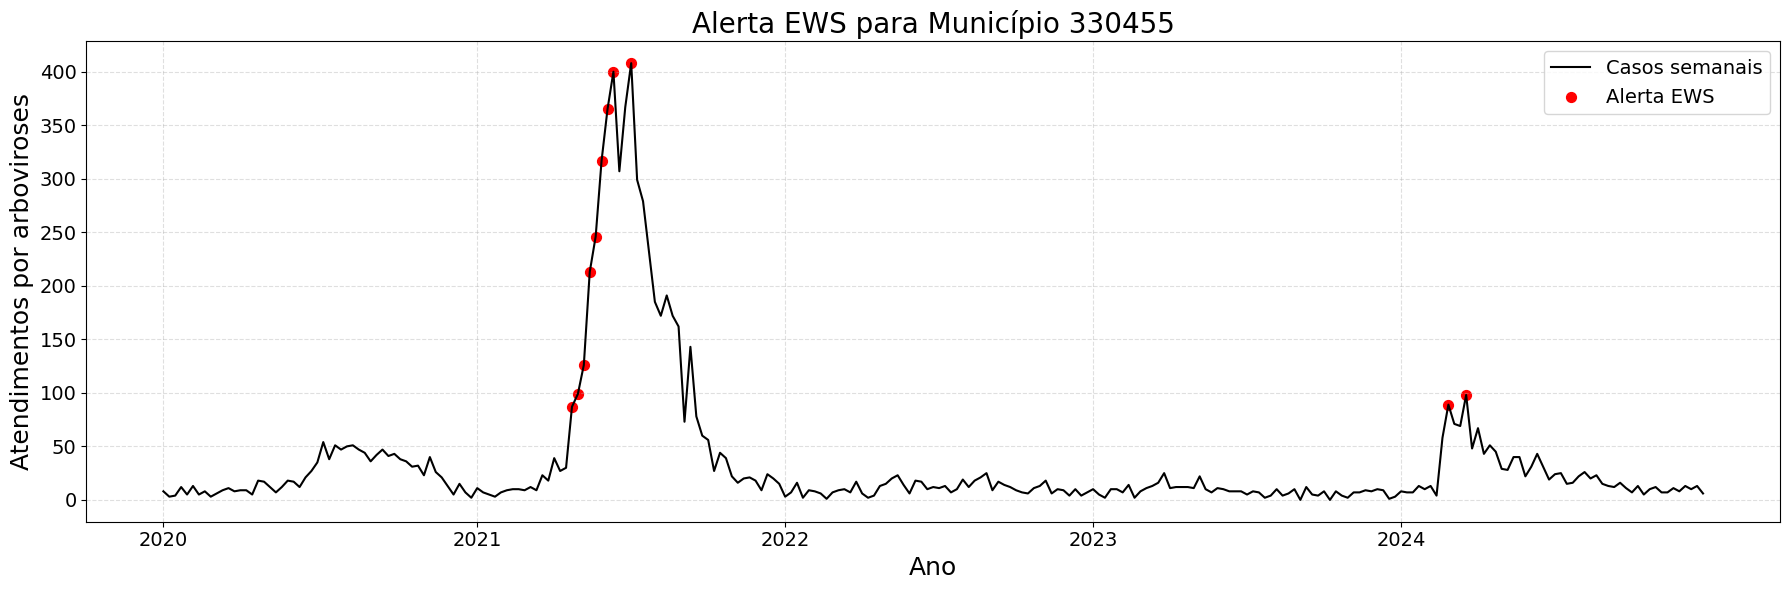

Plotando Município 221100: 261 semanas. Alertas encontrados: {'Não': 240, 'Sim': 21}


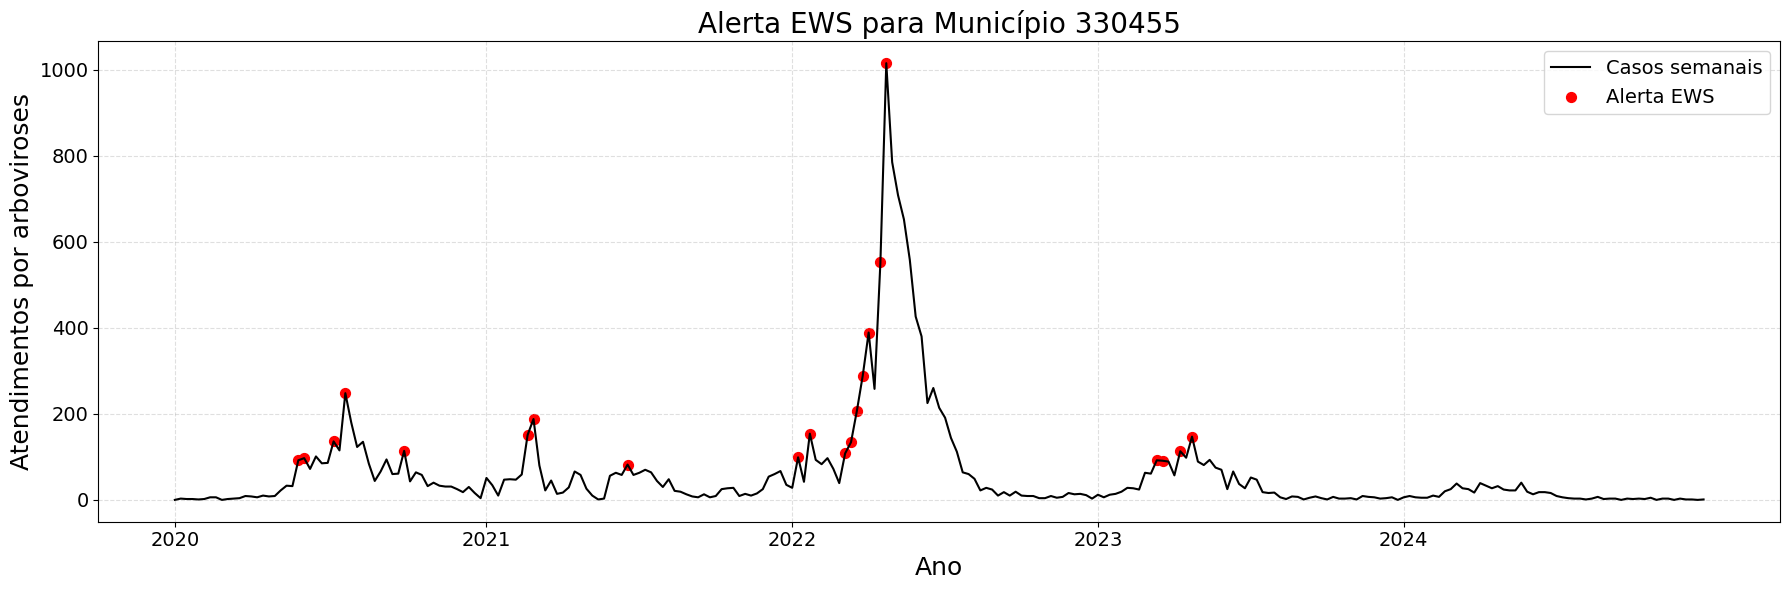

Plotando Município 410690: 261 semanas. Alertas encontrados: {'Não': 248, 'Sim': 13}


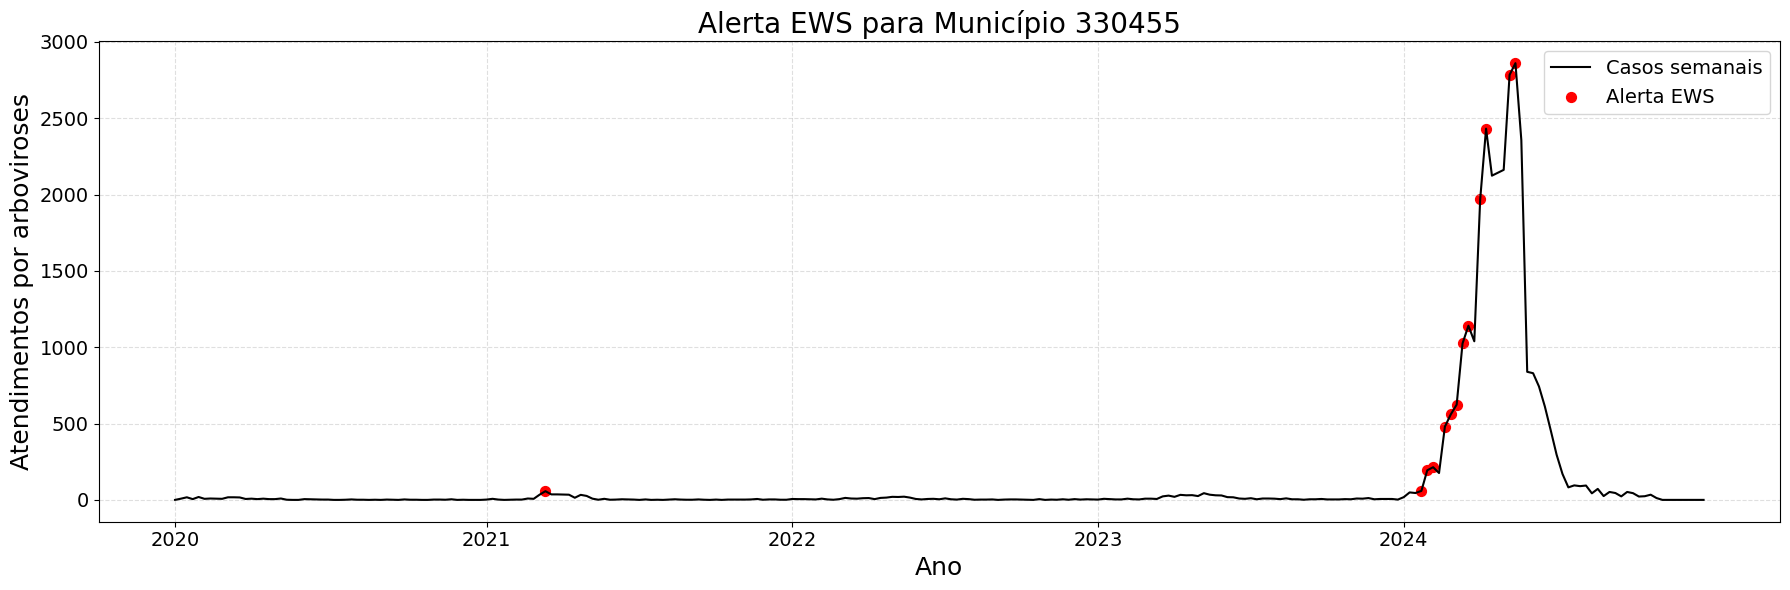

Plotando Município 330455: 261 semanas. Alertas encontrados: {'Não': 248, 'Sim': 13}


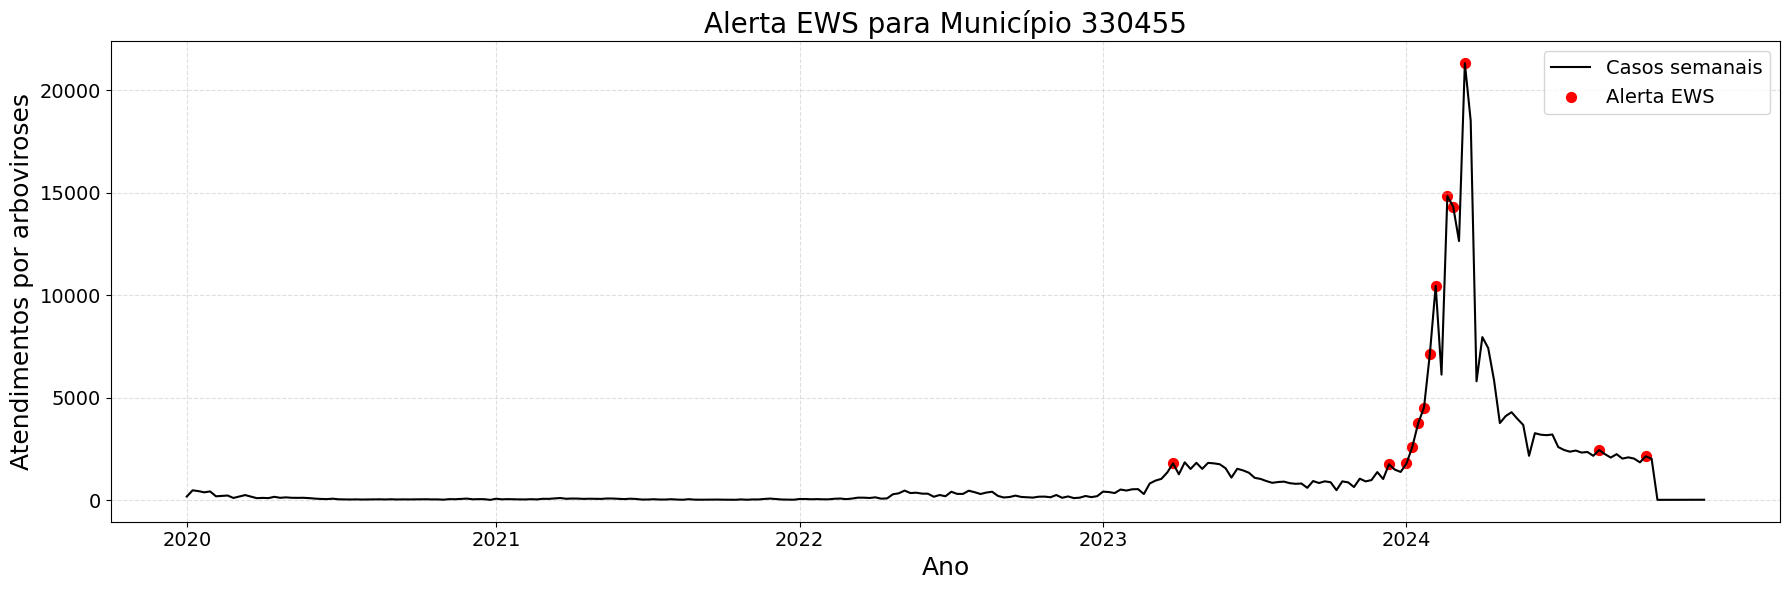

Plotando Município 240810: 261 semanas. Alertas encontrados: {'Não': 245, 'Sim': 16}


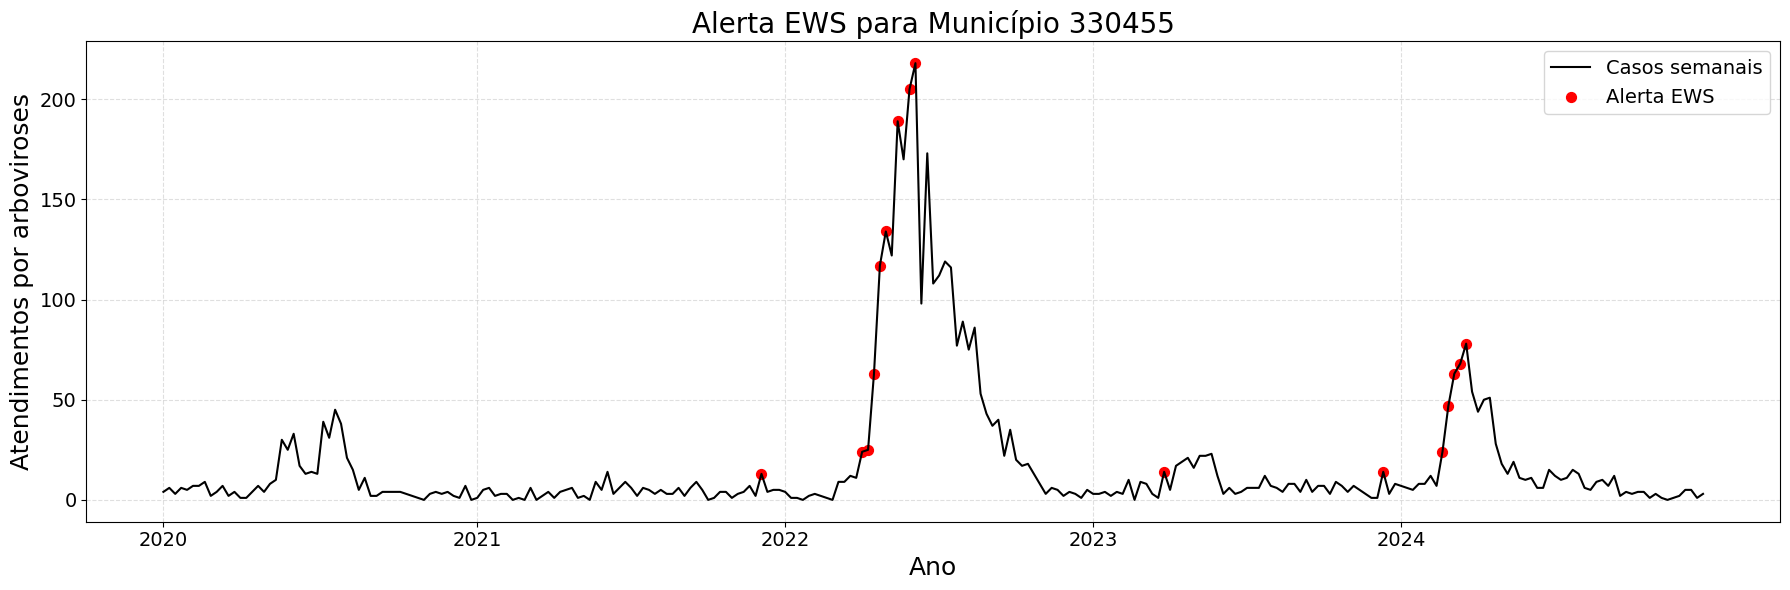

Plotando Município 110020: 261 semanas. Alertas encontrados: {'Não': 236, 'Sim': 25}


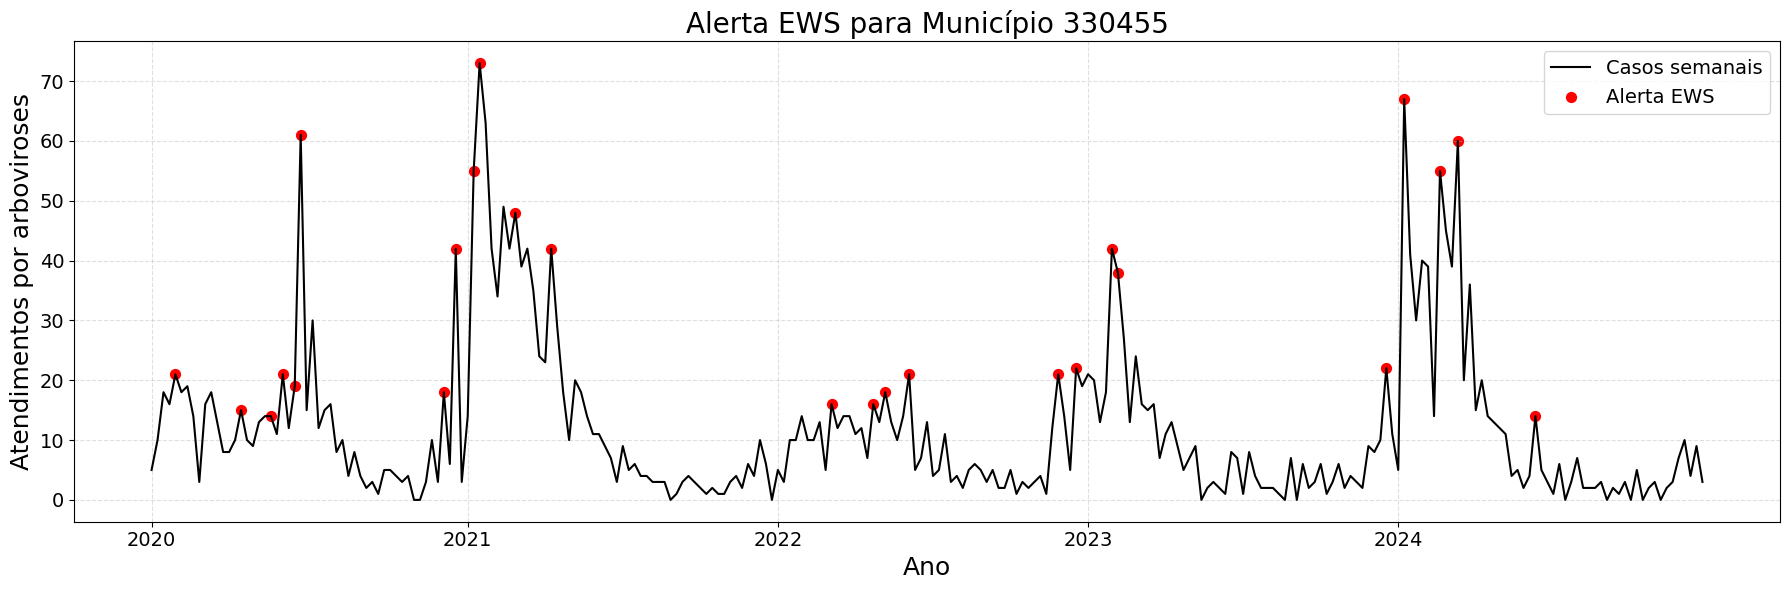

Plotando Município 140010: 261 semanas. Alertas encontrados: {'Não': 253, 'Sim': 8}


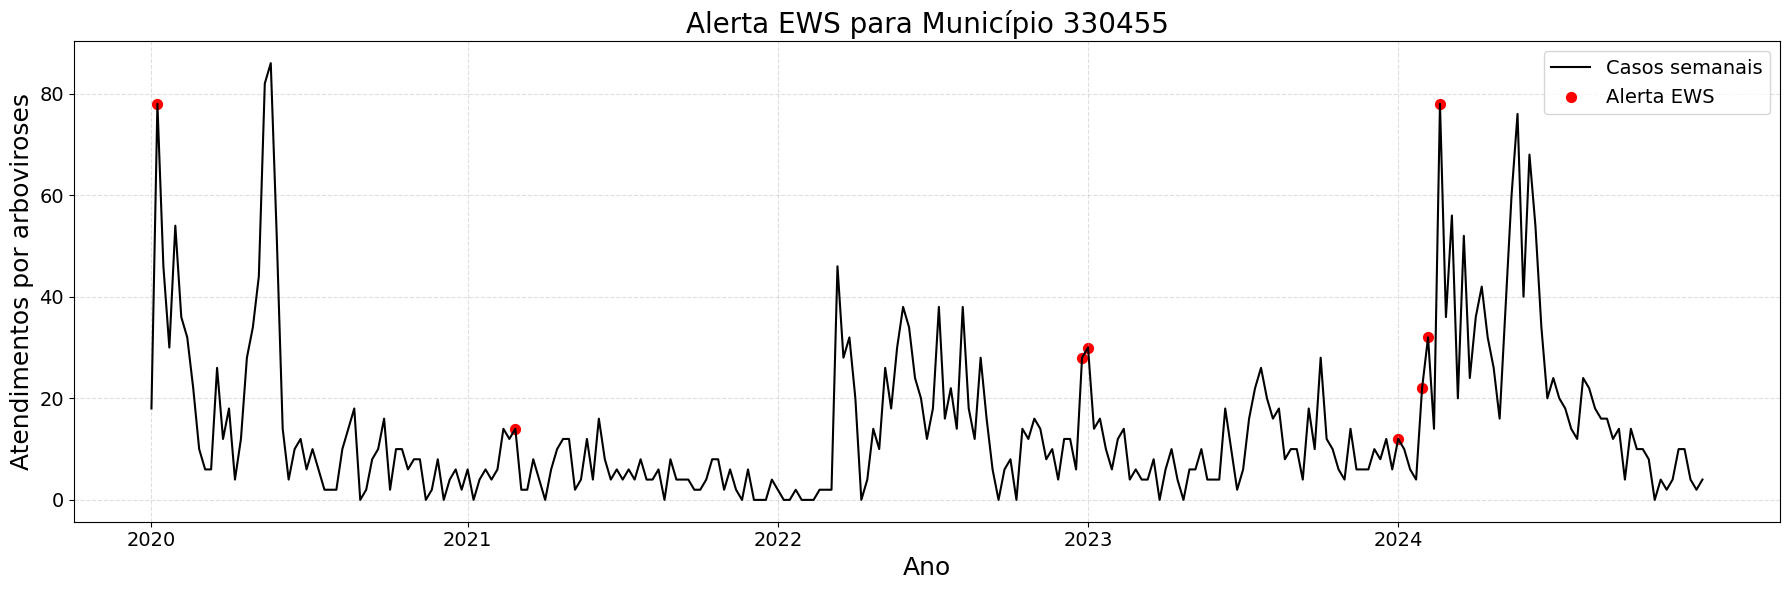

Plotando Município 431490: 261 semanas. Alertas encontrados: {'Não': 218, 'Sim': 43}


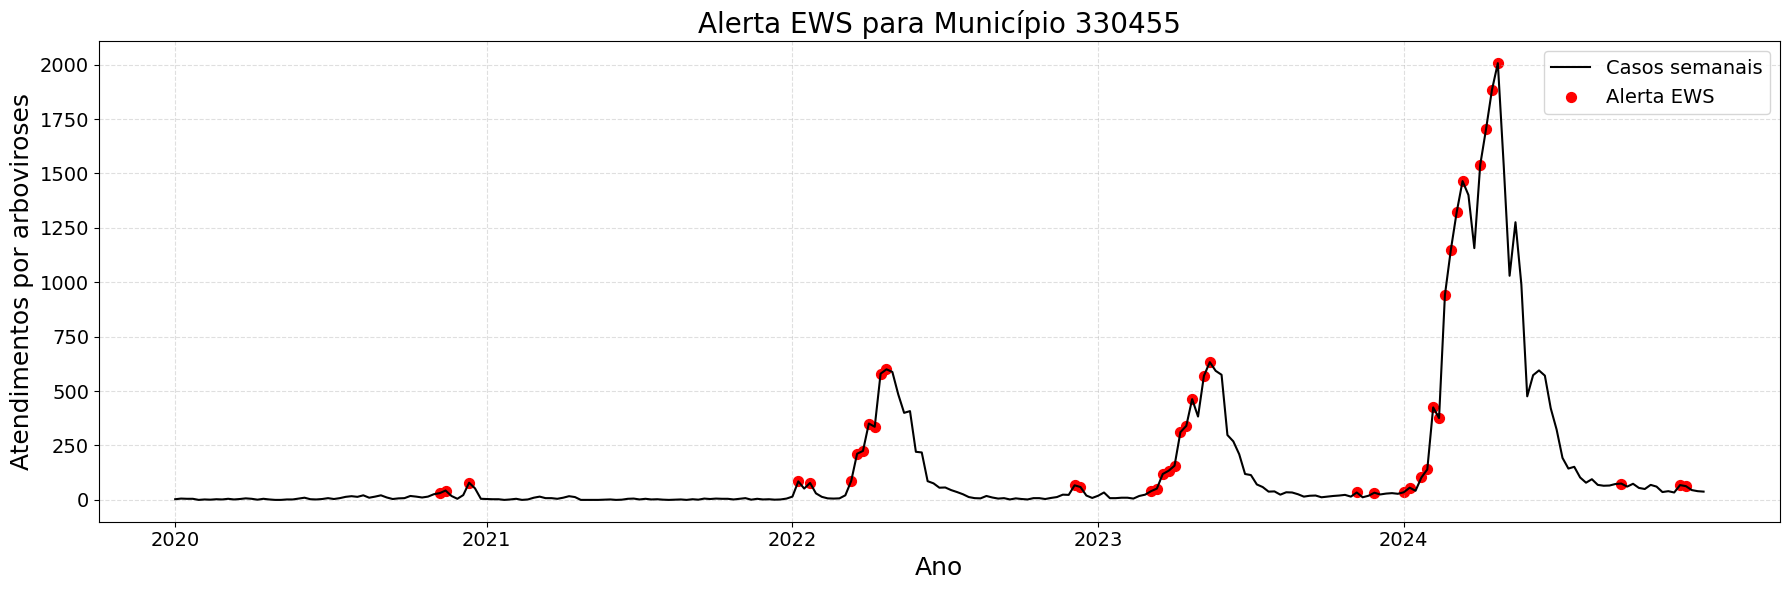

Plotando Município 420910: 261 semanas. Alertas encontrados: {'Não': 181, 'Sim': 80}


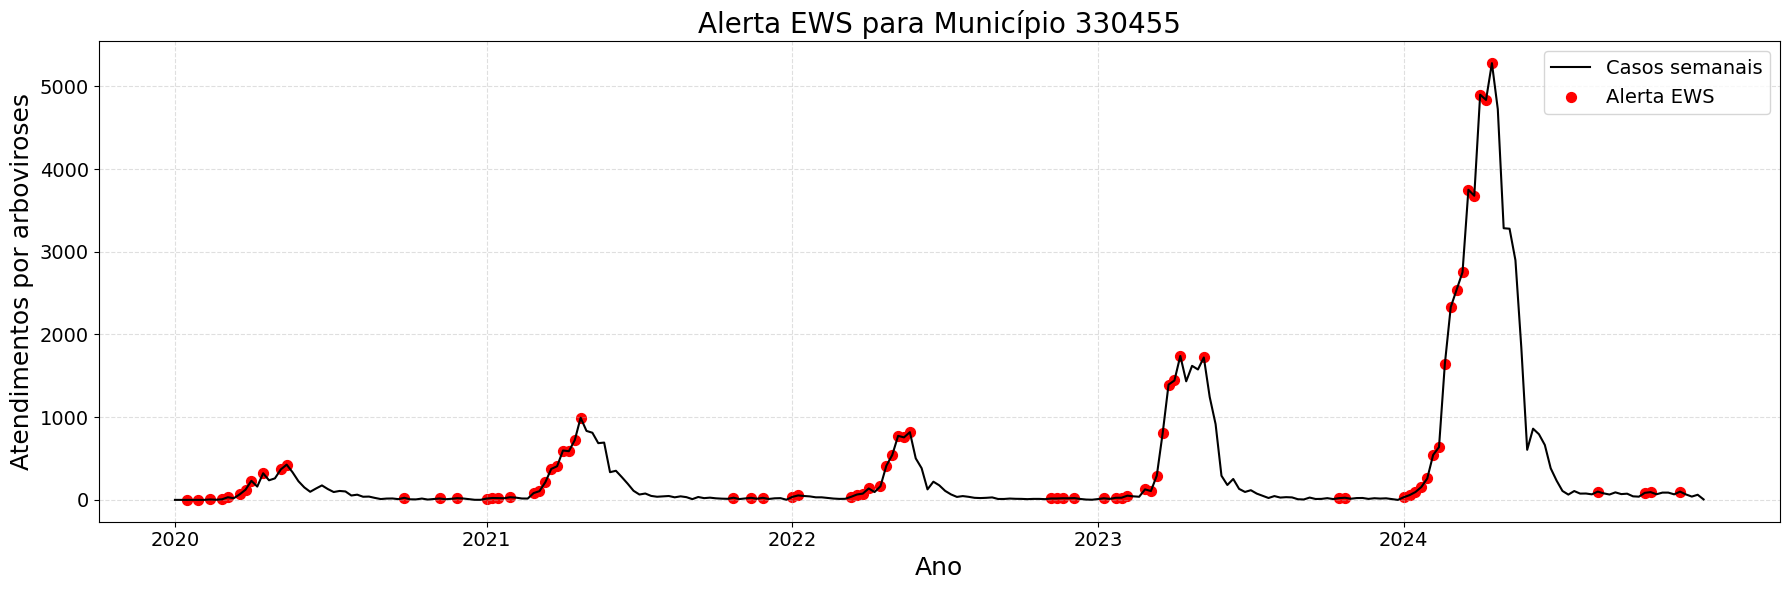

Plotando Município 280030: 261 semanas. Alertas encontrados: {'Não': 215, 'Sim': 46}


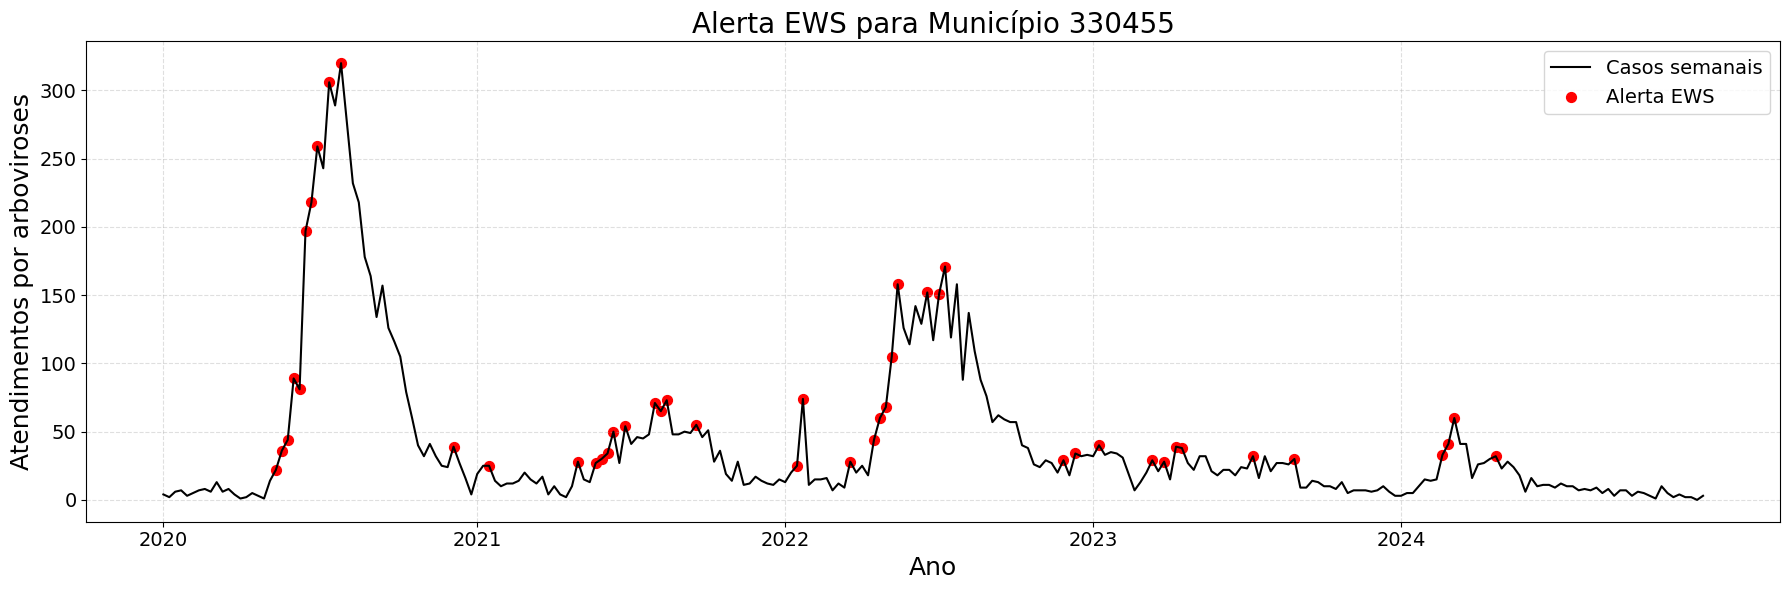

Plotando Município 355030: 261 semanas. Alertas encontrados: {'Não': 249, 'Sim': 12}


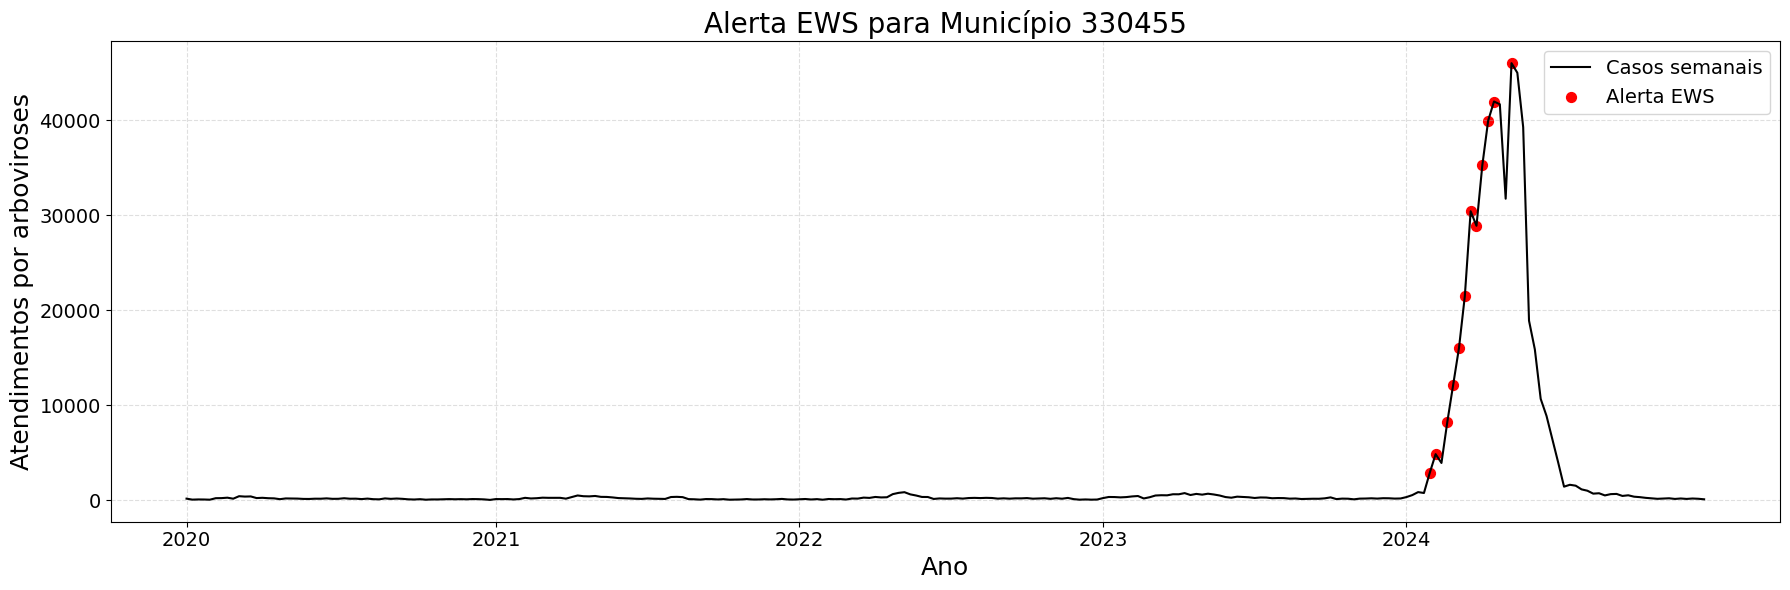

Plotando Município 172100: 261 semanas. Alertas encontrados: {'Não': 239, 'Sim': 22}


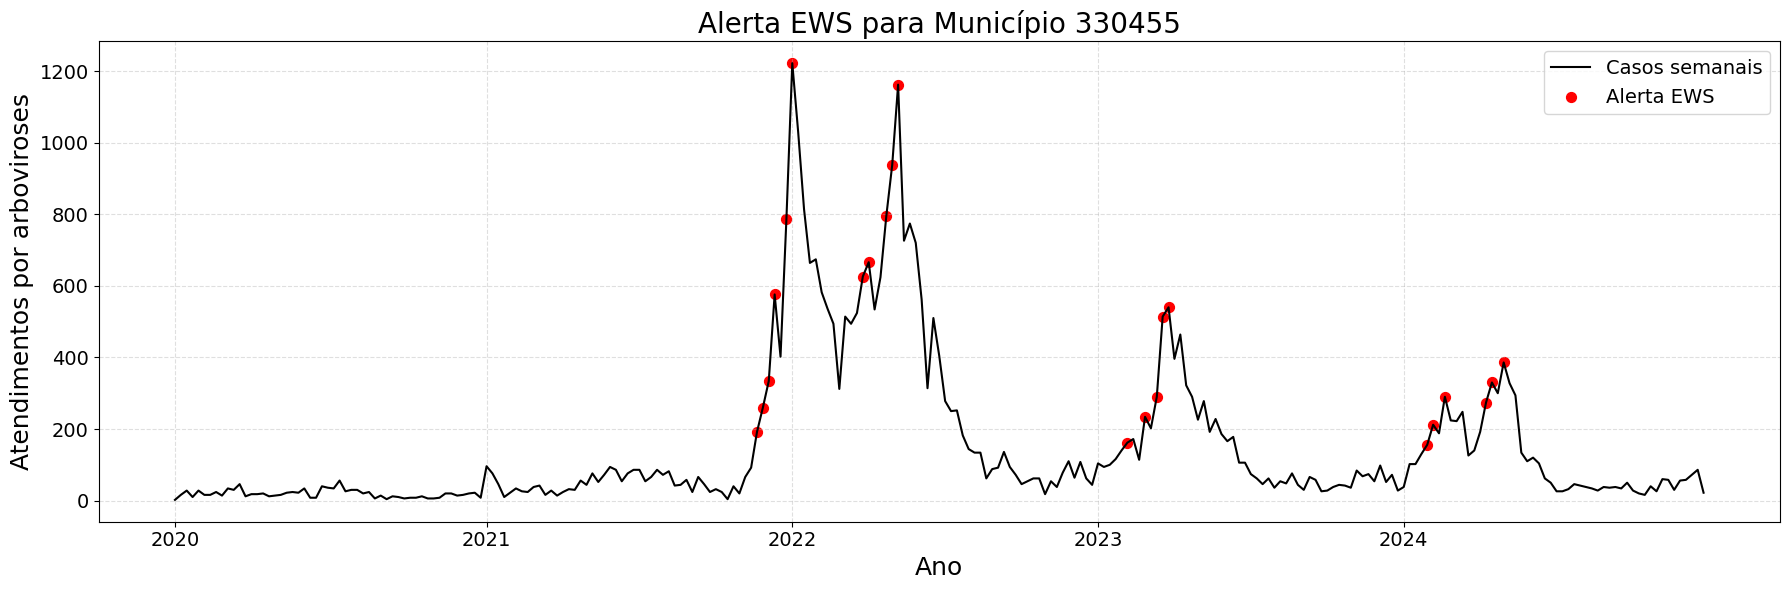

In [72]:
#result_final = pd.read_csv('resultados/EWS_mun_completed_padrao.csv', sep=';')

for cod_ibge in lista_capitais:

    plot_alerta_mun(result_final, cod_ibge, title='Alerta EWS para Município 330455')


In [21]:
#GRAFICOS 

def plot_alerta_por_rgi(result_final, cod_rgi, col_EWS='EWS_Rt', title=None):
    """
    Gera gráfico para uma RGI com atendimentos por arboviroses e alertas do modelo especificado.

    Parâmetros:
        result_final: DataFrame com os dados (como o exportado por EWS_mun_completed.csv)
        cod_rgi: Código da RGI (ex: 290001)
        col_EWS: Coluna do alerta a ser plotado (default: 'EWS_MMAING_VECTOR')
        title: Título opcional do gráfico
    """
    df_rgi = result_final[result_final['cod_rgi'] == cod_rgi].copy()

    if df_rgi.empty:
        print(f"Nenhum dado encontrado para RGI {cod_rgi}")
        return

    df_rgi = df_rgi.sort_values(by=['epiyear', 'epiweek']).reset_index(drop=True)
    df_rgi['semanas'] = range(1, len(df_rgi) + 1)

    # Ticks no início de cada ano
    anos = df_rgi['epiyear'].unique()
    ticks = [df_rgi[df_rgi['epiyear'] == ano]['semanas'].iloc[0] for ano in anos]

    print(f"Plotando RGI {cod_rgi}: {len(df_rgi)} semanas. Alertas encontrados: {df_rgi[col_EWS].value_counts().to_dict()}")

    plt.figure(figsize=(18, 6))
    plt.plot(df_rgi['semanas'], df_rgi['atend_arbov'], color='black', label=f'RGI {cod_rgi} - Casos semanais')

    alertas = df_rgi[df_rgi[col_EWS] == "Sim"]
    if not alertas.empty:
        plt.scatter(alertas['semanas'], alertas['atend_arbov'], color='red', label='EWS', s=50)

    plt.title(title if title else f'Alerta {col_EWS} - RGI {cod_rgi}', fontsize=20)
    plt.xlabel('Ano (semana contínua)', fontsize=18)
    plt.ylabel('Atendimentos por arboviroses', fontsize=18)
    plt.xticks(ticks, anos, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.show()


In [22]:

plot_alerta_por_rgi(result_final, cod_rgi=292740, title='')


TypeError: plot_alerta_por_rgi() got an unexpected keyword argument 'cod_rgi'